# Basalt Glass FTIR Baselines
Calculating principle component vectors for FTIR Baselines for CO_2 and H_2O between 1275 and 2200 cm^-1 from a database of spectra from volatile free basaltic glasses 

In [3]:
# Importing Packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
import glob
from scipy import signal
from scipy import interpolate
from pathlib import Path
 
font = {'family': 'Avenir Next',
        'weight': 'normal',
        'size': '18'}
plt.rc('font', **font)

In [4]:
#Database Names of spectra. 
NoH2O_rough_select2 = "NoH2O_rough_select2.csv"  # removes Newman Baseline which doenst go higher than 2400
original_cleaned = "Dans_Data_raw_cleaned.csv" 

# This is where I select which database is used to make the baselines and make dataframes.

# H2O free spectra. 
DB_Name = NoH2O_rough_select2  # NoH2O_Path_smoothed #original #NoH2O_Path_smoothed #Path_Raw_cleaned2
DB_Path = Path.cwd().joinpath(DB_Name)
df_cleaned = pd.read_csv(DB_Path, index_col="Wavenumber")
frame = df_cleaned
Wavenumber = df_cleaned.index

# All Spectra including those with H2O
H2O_DB_Name = original_cleaned  # Path_Raw_cleaned2 #original_cleaned
H2O_DB_Path = Path.cwd().joinpath(H2O_DB_Name)
H2O_df_cleaned = pd.read_csv(H2O_DB_Path, index_col="Wavenumber")
H2O_frame = H2O_df_cleaned
H2O_Wavenumber = H2O_df_cleaned.index


In [5]:
def Lorentzian(x, center, half_width, amp=1):
    # L = amp * (half_width ** 2 / (half_width ** 2 + (2 * x - 2 * center) ** 2))
    V = (x - center) / (half_width / 2)
    L = amp * 1 / (1 + V**2)
    return L

def Gauss(x, mu, sd, A=1):
    G = A * np.exp(-((x - mu) ** 2) / (2 * sd**2))
    return G

In [6]:
# Note This Isnt used else where cut if code works. 
# def linear(x, m):
#     # creates a linear line  based on a slope centered on y = 0  
#     line = x * m
#     line = line - np.mean(line)
#     return line

In [7]:
def basic_scale_data(Data, Wavenumber):
    """
    Scales the data only
    """
    # Data = Data - Data.mean(axis =0)
    data_range = Data[0, :] - Data[-1, :]
    scaled_data = Data / np.abs(data_range)

    Data = scaled_data - scaled_data[0, :] + 0.5
    Mean_baseline = Data.mean(axis=1)

    return Data, Mean_baseline



# Normalize Data for scaling
def scale_data(Data, Wavenumber):
    """
    Scales the data and subtracts the mean spectrum
    """
    # Data = Data - Data.mean(axis =0)
    data_range = Data[0, :] - Data[-1, :]
    scaled_data = Data / np.abs(data_range)

    Data = scaled_data - scaled_data[0, :] + 0.5
    Mean_baseline = Data.mean(axis=1)
    Data = Data - np.array([Mean_baseline]).T
    return Data, Mean_baseline

In [8]:
# Select subset of the database spectra by wavenumber

# wn_high = 1500
wn_low = 1275  # 1250
wn_low_init = wn_low

wn_high =  2200  # 2400
wn_high_init = wn_high

# wn_low = 1800
# wn_low = 1500
Wavenumber = frame.loc[wn_low:wn_high].index
Wavenumber_full = Wavenumber
frame_select = frame.loc[wn_low:wn_high]
Data_init = frame_select.values

H2O_frame_select = H2O_frame.loc[wn_low:wn_high]
H2O_Data_init = H2O_frame_select.values
H2O_Data__scale, H2O_Mean_baseline_scale = basic_scale_data(H2O_Data_init, Wavenumber)

In [9]:
#%%
def savgol_filter(x, smooth_width, poly_order):
    return signal.savgol_filter(x, smooth_width, poly_order)

def interp_smooth(spectrum, Wavenumber=Wavenumber):
    # Interpolate spectrum to smooth it and fix start and end points
    w = np.ones_like(Wavenumber)
    w[0] = 100
    w[-1] = 100
    interp = interpolate.UnivariateSpline(
        x=Wavenumber, y=spectrum, k=5, s=0.01, ext=0, w=w
    )
    return interp(Wavenumber)

In [10]:
def smoothing_protocol(Data_values, Wavenumber=Wavenumber, split_wn = 1500):
    """
    Protocol for smoothing spectra. Smooth noise and interference fringes in baselines. Processes low and high have numbers seperately to avoid changing baselines under the peaks and 
    Cut sections have 50 cm^-1 overlap
    """

    # Cut spectra at point closest to split_Wn to make low and high wavenumber selections. 
    section_idx = np.where(np.round(Wavenumber) == split_wn)[0][
        0
    ]  
    
    # Smooth low wavenumbers
    Smooth_section1 = np.apply_along_axis(
        savgol_filter,
        0,
        Data_values[0 : section_idx + 50, :],
        smooth_width=91,  # Filter smoothing width
        poly_order=4,
    )
    diff = Smooth_section1 - Data_values[0 : section_idx + 50, :]
    Smooth_diff = np.apply_along_axis(
        interp_smooth, 0, diff, Wavenumber=Wavenumber[0 : section_idx + 50]
    )

    # Smooth high wavenumbers
    Smooth_section1 = Smooth_section1 - Smooth_diff
    Smooth_section2 = np.apply_along_axis(
        savgol_filter,
        0,
        Data_values[section_idx - 50 : None, :],
        smooth_width=131,  # 121
        poly_order=4,
    )

    # Cut and Stitch Smoothed Sections
    section_1 = Smooth_section1[0:-50, :]
    section_2 = Smooth_section2[50:None, :]

    offset_sections = section_1[-1] - section_2[0]
    section_1 = section_1 - offset_sections

    Smoothed_start = np.concatenate([section_1, section_2], axis=0)

    w = np.ones_like(Wavenumber)
    w[0:5] = 10
    w[-1:-5] = 10

    interp_data = []

    for array in Smoothed_start.T:
        smoothed_function = interpolate.UnivariateSpline(
            x=Wavenumber, y=array, k=5, w=w, s=0.005
        )
        smoothed_array = smoothed_function(Wavenumber)
        interp_data.append(smoothed_array)

    return Smoothed_start  # np.array(interp_data).T


Smoothed = smoothing_protocol(Data_init)

Smoothed_DF = pd.DataFrame(Smoothed, index=Wavenumber_full.T)

H2O_Data_smooth = smoothing_protocol(H2O_Data_init)

In [11]:
Data_raw, Mean_baseline_raw = basic_scale_data(Data_init, Wavenumber)
Data_raw_smoothed, Mean_baseline_raw_smoothed = basic_scale_data(Smoothed, Wavenumber)

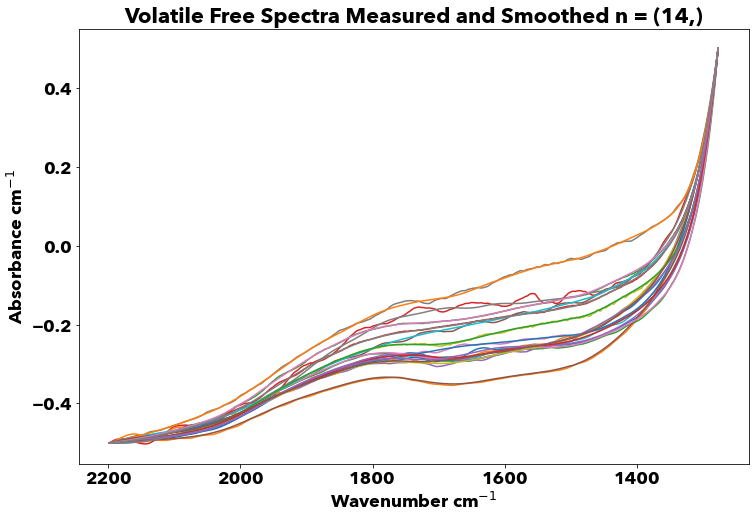

In [12]:
# Plot Volatitle Free Spectra 
Scaled_Data = basic_scale_data(Data_init, Wavenumber)
Scaled_Smoothed = basic_scale_data(Smoothed, Wavenumber)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(Wavenumber, Scaled_Data[0])
plt.plot(Wavenumber, Scaled_Smoothed[0])
ax.set_ylabel(f"Absorbance cm$^{{-1}}$")
ax.set_xlabel(f"Wavenumber cm$^{{-1}}$")
ax.set_title(f"Volatile Free Spectra Measured and Smoothed n = {Scaled_Data[0][1].shape}")
ax.invert_xaxis()
plt.savefig("Plots/Volatile Free Spectra.svg")

In [13]:
# # NOTE What is going on here? Am I going to use smoothed or raw
# """ This section might not matter """

# # Data_start = Smoothed
# Data_start = Data_init

# Data, Mean_baseline = scale_data(Data_start, Wavenumber)
# Smooth_Data, Smooth_Mean_baseline = scale_data(Smoothed, Wavenumber)

In [14]:
Smooth_Data, Smooth_Mean_baseline = scale_data(Smoothed, Wavenumber)

# Data, Mean_baseline = Data_smoothed, Mean_baseline_smoothed #Smooth_Data, Smooth_Mean_baseline
Data, Mean_baseline = Smooth_Data, Smooth_Mean_baseline

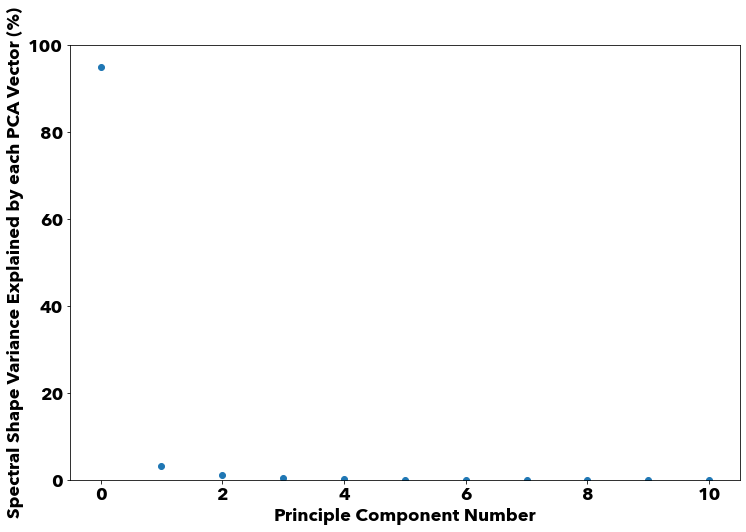

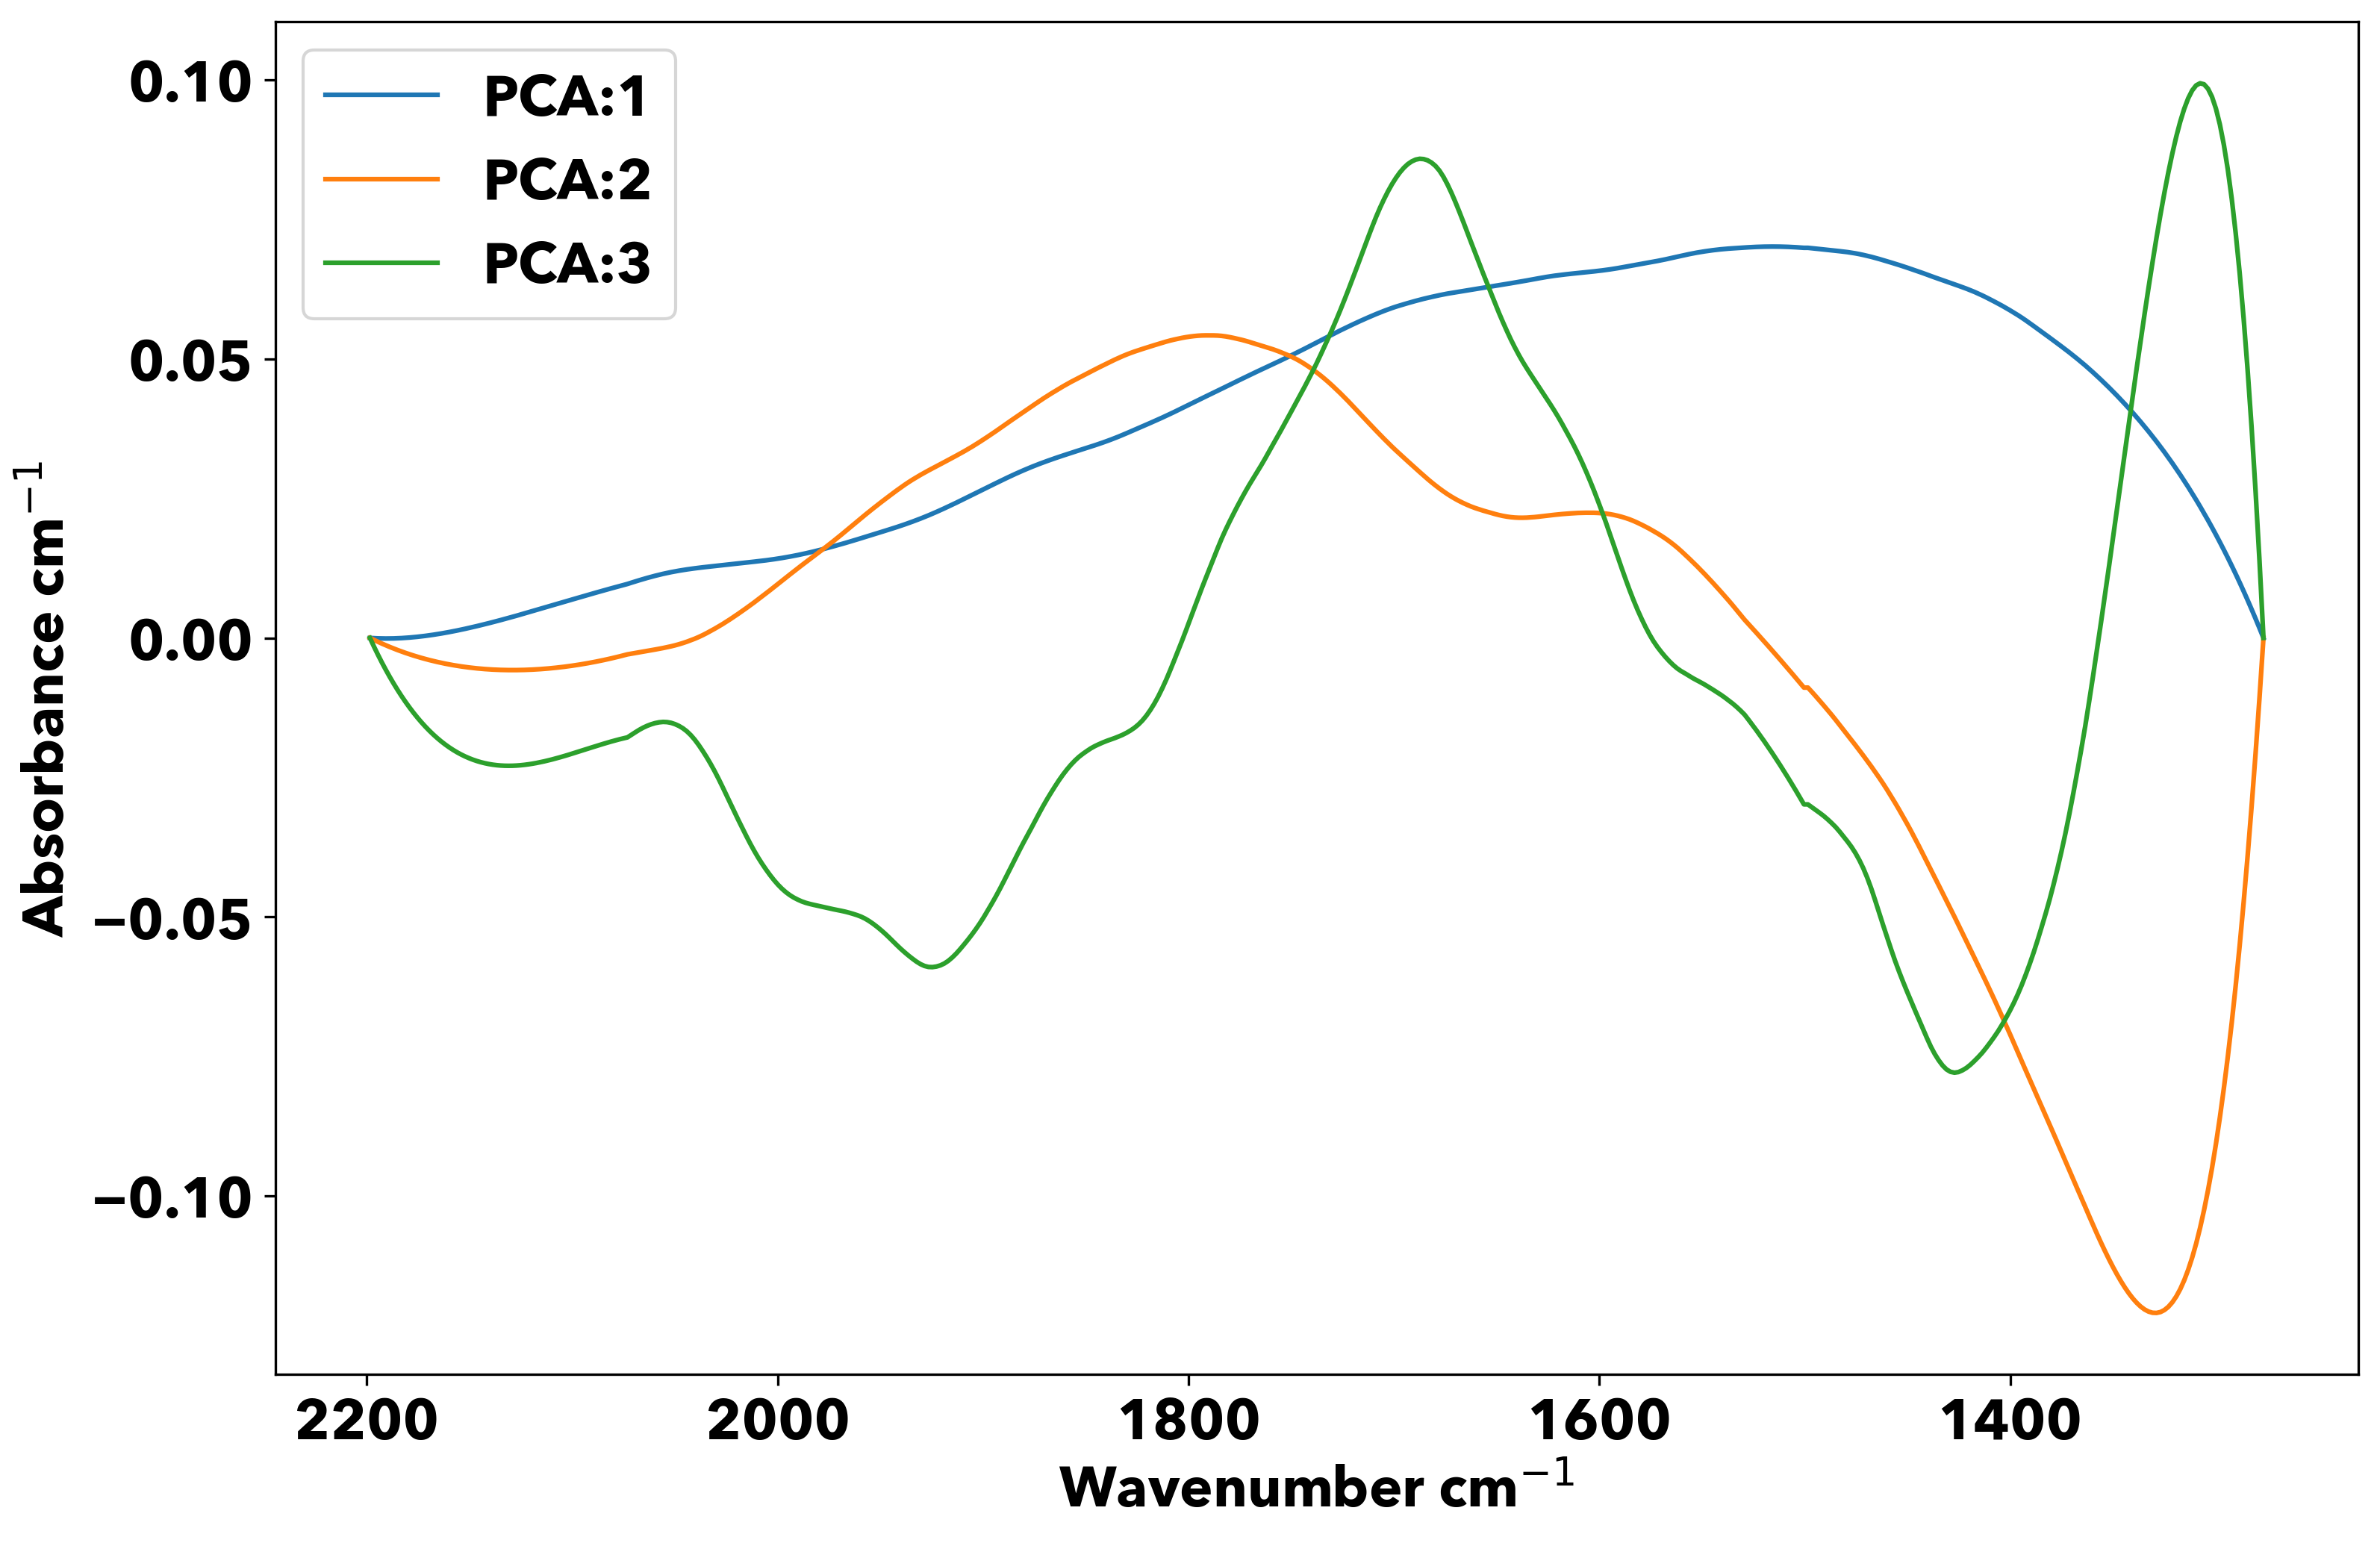

In [15]:
# Calculates the Principle components vectors for initial volatilve free spectra.
pca = PCA(
    12,
)  # Number of PCA vectors to calculate

principalComponents = pca.fit(
    Data.T
)  # everything appears to work best with the raw data or raw data scaled

# Project initial Spectra into the principle components of each. 
reduced_data = pca.fit(Data.T).transform(Data.T)
# %%
# plots the fraction of the variance explained by each PCA vector
fig, ax = plt.subplots(figsize=(12, 8))
variance = pca.explained_variance_
variance_norm = variance[0:-1] / np.sum(variance[0:-1])
plt.plot(variance_norm * 100, marker="o", linestyle="None")
ax.set_xlabel("Principle Component Number")
ax.set_ylabel(f"Spectral Shape Variance Explained by each PCA Vector (%)")
ax.set_ylim(0,100)
pca.singular_values_
PCA_vectors = pca.components_
plt.savefig("Plots/Initial_Spectra_PCA_Variance_plot.png")


# %%
# Plots the first several principle components

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
plt.plot(Wavenumber, PCA_vectors[0], label="PCA:1")
plt.plot(Wavenumber, PCA_vectors[1], label="PCA:2")
plt.plot(Wavenumber, PCA_vectors[2], label="PCA:3")
#plt.plot(Wavenumber, PCA_vectors[3], label="PCA:4")
# plt.plot(Wavenumber, PCA_vectors[4], label="PCA:5")
# plt.plot(Wavenumber, PCA_vectors[5], label="PCA:6")
# plt.plot(Wavenumber, PCA_vectors[6], label="PCA:7")
# plt.plot(Wavenumber, PCA_vectors[7], label="PCA:8")

# PCA3_Smooth = signal.savgol_filter(PCA_vectors[2], 65, 3)
# plt.plot(Wavenumber, PCA3_Smooth, label="PCA3_Smooth")

plt.legend()
ax.invert_xaxis()
ax.legend()
ax.set_ylabel(f"Absorbance cm$^{{-1}}$")
ax.set_xlabel(f"Wavenumber cm$^{{-1}}$")
plt.savefig("Plots/Initial_Spectra_component_plot.png")

In [16]:
# Save PCA Vectors and Mean
Mean_base = pd.Series(Mean_baseline, index=Wavenumber, name="Average_Baseline")
Baseline_DF = pd.DataFrame(
    PCA_vectors[0:4].T, index=Wavenumber, columns=("PCA_1", "PCA_2", "PCA_3", "PCA_4")
)
Baseline_Database = pd.concat([Mean_base, Baseline_DF], axis=1)
Baseline_Database.to_csv("Results/Initial_VolatileFree_Spectra_Avg+PCA.csv")

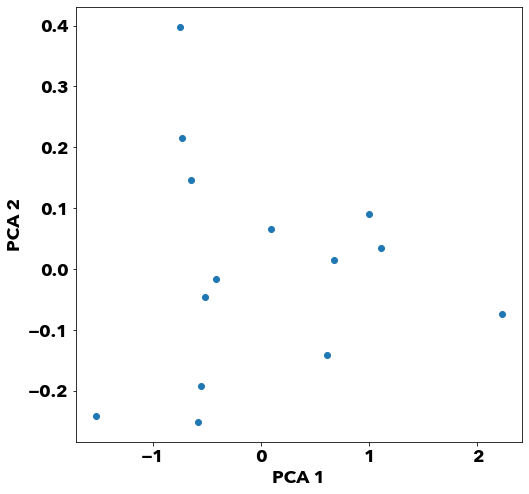

In [17]:
# Plots the baseline database in terms of PCA component.
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

#%%
# PCA vector ranges
PCA_max_Prior = reduced_data.max(axis=0)
PCA_min_Prior = reduced_data.min(axis=0)
plt.savefig("Plots/PC Reduced Projection of Initial Spectra Data.png")
# %%

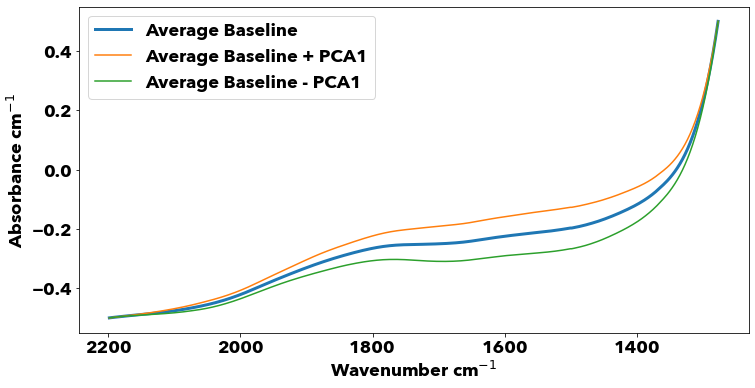

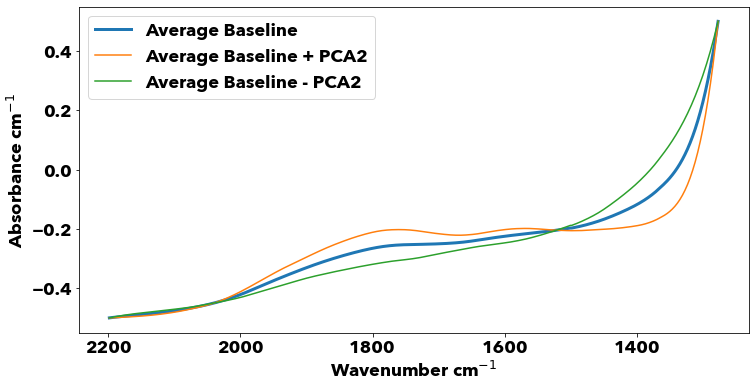

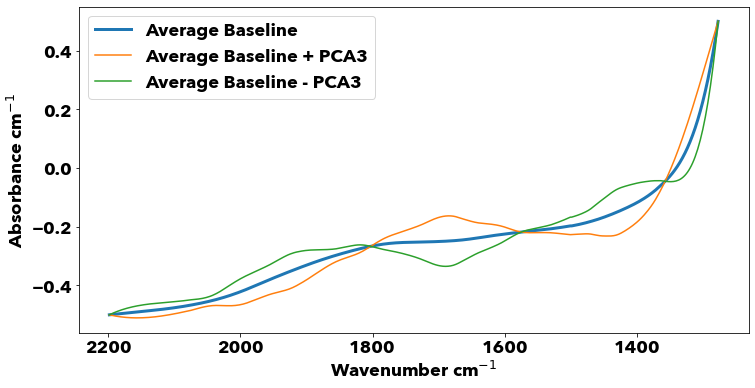

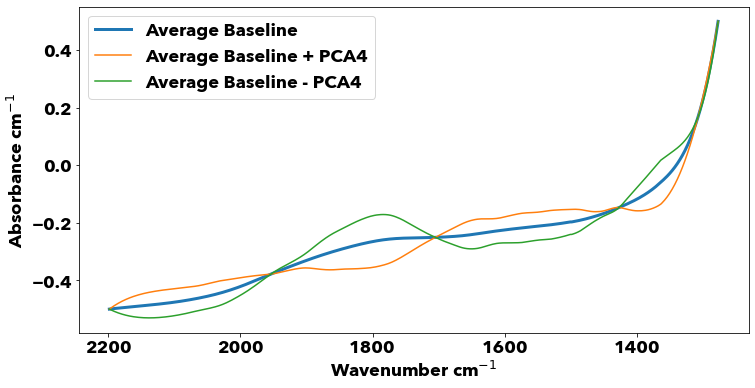

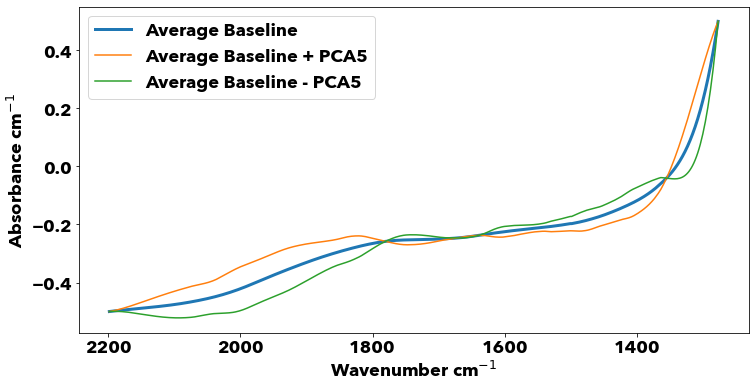

In [18]:
# Plots Average spectrum with PCA components added and subtracted. 

fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(Wavenumber, Mean_baseline, label="Average Baseline", linewidth=3)
plt.plot(Wavenumber, Mean_baseline + PCA_vectors[0], label="Average Baseline + PCA1")
plt.plot(Wavenumber, Mean_baseline - PCA_vectors[0], label="Average Baseline - PCA1")
# plt.plot(Wavenumber, Mean_baseline-PCA_vectors[0]*2, label = 'Average Baseline - PCA1 *2')

plt.legend()
ax.invert_xaxis()
ax.legend()
ax.set_ylabel(f"Absorbance cm$^{{-1}}$")
ax.set_xlabel(f"Wavenumber cm$^{{-1}}$")
plt.savefig("Plots/_Initial_Spectra_PCA1+mean_plot_.png")

#%%
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(Wavenumber, Mean_baseline, label="Average Baseline", linewidth=3)
plt.plot(Wavenumber, Mean_baseline + PCA_vectors[1], label="Average Baseline + PCA2")
plt.plot(Wavenumber, Mean_baseline - PCA_vectors[1], label="Average Baseline - PCA2")
# plt.plot(Mean_baseline-PCA_vectors[1]*2, label = 'Average Baseline + PCA2 *2')

plt.legend()
ax.invert_xaxis()
ax.legend()
ax.set_ylabel(f"Absorbance cm$^{{-1}}$")
ax.set_xlabel(f"Wavenumber cm$^{{-1}}$")
plt.savefig("Plots/_Initial_Spectra_PCA2+mean_plot.png")

#%%
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(Wavenumber, Mean_baseline, label="Average Baseline", linewidth=3)
plt.plot(Wavenumber, Mean_baseline + PCA_vectors[2], label="Average Baseline + PCA3")
plt.plot(Wavenumber, Mean_baseline - PCA_vectors[2], label="Average Baseline - PCA3")
# plt.plot(Mean_baseline-PCA_vectors[1]*2, label = 'Average Baseline + PCA2 *2')

plt.legend()
ax.invert_xaxis()
ax.legend()
ax.set_ylabel(f"Absorbance cm$^{{-1}}$")
ax.set_xlabel(f"Wavenumber cm$^{{-1}}$")
plt.savefig("Plots/_Initial_Spectra_PCA3+mean_plot.png")
#%%
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(Wavenumber, Mean_baseline, label="Average Baseline", linewidth=3)
plt.plot(
    Wavenumber, Mean_baseline + PCA_vectors[3] * 1, label="Average Baseline + PCA4"
)
plt.plot(
    Wavenumber, Mean_baseline - PCA_vectors[3] * 1, label="Average Baseline - PCA4"
)
# plt.plot(Mean_baseline-PCA_vectors[1]*2, label = 'Average Baseline + PCA2 *2')

plt.legend()
ax.invert_xaxis()
ax.legend()
ax.set_ylabel(f"Absorbance cm$^{{-1}}$")
ax.set_xlabel(f"Wavenumber cm$^{{-1}}$")
plt.savefig("Plots/_Initial_Spectra_PCA4+mean_plot.png")

#%%
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(Wavenumber, Mean_baseline, label="Average Baseline", linewidth=3)
plt.plot(
    Wavenumber, Mean_baseline + PCA_vectors[4] * 1, label="Average Baseline + PCA5"
)
plt.plot(
    Wavenumber, Mean_baseline - PCA_vectors[4] * 1, label="Average Baseline - PCA5"
)
# plt.plot(Mean_baseline-PCA_vectors[1]*2, label = 'Average Baseline + PCA2 *2')

plt.legend()
ax.invert_xaxis()
ax.legend()
ax.set_ylabel(f"Absorbance cm$^{{-1}}$")
ax.set_xlabel(f"Wavenumber cm$^{{-1}}$")
plt.savefig("Plots/_Initial_Spectra_PCA5+mean_plot.png")

## Producing H2O Free spectra

In [21]:
# Make Dataframes without Water peak for improved to fit
def H2O_peak_cut(df, wn_cut_low, wn_cut_high, return_DF=False):
    No_Peaks_Frame = df.drop(df[wn_cut_low:wn_cut_high].index)

    if return_DF == True:
        return No_Peaks_Frame

    No_Peaks_Wn = No_Peaks_Frame.index
    No_Peaks_Data = No_Peaks_Frame.values
    return No_Peaks_Wn, No_Peaks_Data


In [22]:
# NOTE leaving the test code below for initial trial. 
# wn_cut_low, wn_cut_high = (1521, 1730) # Before 3/22/21
# wn_cut_low, wn_cut_high = (1450, 1800) #after 3/22/21
# wn_cut_low, wn_cut_high = (1500, 1771)  # after 4/24/21  (1490, 1771)
wn_cut_low, wn_cut_high = (1510, 1771)  # after 5/12/21
Full_No_Peaks_Wn, Full_No_Peaks_Values = H2O_peak_cut(
    H2O_frame_select, wn_cut_low, wn_cut_high
)

n_PCA_vectors = 4  # 4 but after 5/10/21 2
H2O_free_PCA_DF = pd.DataFrame(PCA_vectors[0:n_PCA_vectors].T, index=Wavenumber)
PCA_No_Peaks_DF = H2O_peak_cut(H2O_free_PCA_DF, wn_cut_low, wn_cut_high, return_DF=True)

Average_baseline = pd.Series(Mean_baseline, index=Wavenumber)
Avg_BSL_no_peaks = H2O_peak_cut(
    Average_baseline, wn_cut_low, wn_cut_high, return_DF=True
)
Avg_BSL_no_peaks_Wn = Avg_BSL_no_peaks.index

tilt = pd.Series(np.arange(0, len(Average_baseline)), index=Wavenumber)
tilt_cut = H2O_peak_cut(tilt, wn_cut_low, wn_cut_high, return_DF=True)


In [23]:
# Synthetic Peaks Choose peak shape, position and width. In the future these will be fit parameters

# H2O peak
Peak1 = pd.Series(
    Lorentzian(x=Wavenumber, center=1635, half_width=55, amp=1), index=Wavenumber
)

# Carbonate Peaks
Peak2 = pd.Series(Gauss(x=Wavenumber, mu=1430, sd=30, A=1), index=Wavenumber)
Peak3 = pd.Series(Gauss(x=Wavenumber, mu=1515, sd=30, A=1), index=Wavenumber)

In [24]:
# Function to fit the baselines:
# uses the PCA components and the synthetic peaks to made linear combinations that fit the data. T


def Carbonate_baseline_fit(
    Spec,
    Average_baseline,
    PCA_vectors,
    n_PCA_vectors=2,
    Peak1=Peak1,
    Peak2=Peak2,
    Peak3=Peak3,
):

    PCA_DF = pd.DataFrame(PCA_vectors[0:n_PCA_vectors].T, index=Wavenumber)

    offset = pd.Series(np.ones(len(Peak2)), index=Wavenumber) # an array of ones used to offset model results to meatch the meaured spectra
    tilt = pd.Series(np.arange(0, len(Peak2)), index=Wavenumber) # a linear line used to tilt the modeled results to match the spectra

    # Baseline_Matrix = pd.concat([ Average_baseline, PCA_DF, offset, tilt, Peak2, Peak3], axis=1)

    # This line is only used if we are fitting the Water peak with the CO2 peak.
    Baseline_Matrix = pd.concat(
        [Average_baseline, PCA_DF, offset, tilt, Peak2, Peak3, Peak1], axis=1
    )

    Baseline_Matrix = np.matrix(Baseline_Matrix)

    fit_param = np.linalg.lstsq(Baseline_Matrix, Spec)

    return Baseline_Matrix, fit_param


In [25]:
# plots the results


def plot_Baseline_results(Spectrum, Baseline_Matrix, fit_param, Wavenumber):
    modeled_basline = (
        np.matrix(Baseline_Matrix[:, 0:-3]) * fit_param[0][0:-3]
    )  # Ignores the Peaks in fit.

    # modeled_basline = np.matrix(
    #   Baseline_Matrix[:, 0:-2])*fit_param[0][0:-2]  # Ignores the Peaks in fit. Only for CO2 peaks

    fig, ax = plt.subplots(figsize=(12, 6))
    # plt.plot(Wavenumber,Spectrum.values, label = "Spectrum") for Pandas
    plt.plot(Wavenumber, Spectrum, label="Spectrum")

    plt.plot(Wavenumber, np.matrix(Baseline_Matrix) * fit_param[0], label="Modeled Fit")
    plt.plot(Wavenumber, modeled_basline, label="Baseline")

    # Peak1_amp = fit_param[0][-1]
    # Peak2_amp = fit_param[0][-3]
    # Peak3_amp = fit_param[0][-2]

    ax.invert_xaxis()
    ax.legend()
    ax.set_xlabel("Wavenumber")
    ax.set_ylabel("Absorbance")
    return ax


In [26]:
# Function to fit Water free baselines
# uses the PCA components and the synthetic peaks to mad elinear combinations that fit the data. T


def No_H2O_fit(Spec, Average_baseline, PCA_DF, tilt, Wavenumber=Wavenumber):

    offset = pd.Series(np.ones(len(Average_baseline)), index=Wavenumber)
    # tilt = pd.Series(np.arange(0, len(Average_baseline)), index=Wavenumber)

    Baseline_Matrix = pd.concat(
        [
            Average_baseline,
            PCA_DF,
            offset,
            tilt,
        ],
        axis=1,
    )

    Baseline_Matrix = np.matrix(Baseline_Matrix)

    fit_param = np.linalg.lstsq(Baseline_Matrix, Spec)

    return Baseline_Matrix, fit_param

In [27]:
def plot_NoH2O_results(Spectrum, Baseline_Matrix, fit_param, Wavenumber):

    fig, ax = plt.subplots(figsize=(12, 6))
    # plt.plot(Wavenumber,Spectrum.values, label = "Spectrum") for Pandas
    plt.plot(Wavenumber, Spectrum, label="Spectrum")

    plt.plot(
        Wavenumber,
        np.matrix(Baseline_Matrix) * np.matrix(fit_param[0]).T,
        label="Modeled Fit",
    )

    # Peak1_amp = fit_param[0][-1]
    # Peak2_amp = fit_param[0][-3]
    # Peak3_amp = fit_param[0][-2]

    ax.invert_xaxis()
    ax.legend()
    ax.set_xlabel("Wavenumber")
    ax.set_ylabel("Absorbance")
    return ax

In [28]:
def tilt_fit(Spectrum, Baseline_Matrix, fit_param, Wavenumber):

    offset = pd.Series(np.ones(len(Wavenumber)), index=Wavenumber)
    tilt = pd.Series(np.arange(0, len(Wavenumber)), index=Wavenumber)

    Tilt_Matrix = pd.concat([offset, tilt], axis=1)

    Tilt_Matrix = np.matrix(Tilt_Matrix)

    fit_param = np.linalg.lstsq(Tilt_Matrix, Spec)


/var/folders/3h/h9xj5mr15rnf5gx1cwr12h280000gn/T/ipykernel_1462/1592850446.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit_param = np.linalg.lstsq(Baseline_Matrix, Spec)


<AxesSubplot:xlabel='Wavenumber', ylabel='Absorbance'>

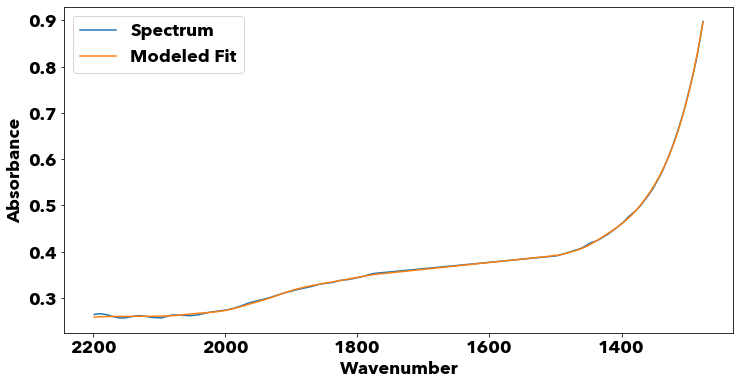

In [29]:
# This line subtracts the mean from your data

Test_Spectrum = Full_No_Peaks_Values[:, 19]
Baseline_Matrix, fit_param1 = No_H2O_fit(
    Spec=Test_Spectrum,
    Average_baseline=Avg_BSL_no_peaks,
    PCA_DF=PCA_No_Peaks_DF,
    Wavenumber=Avg_BSL_no_peaks_Wn,
    tilt=tilt_cut,
)

plot_NoH2O_results(
    Test_Spectrum,
    Baseline_Matrix=Baseline_Matrix,
    fit_param=fit_param1,
    Wavenumber=Avg_BSL_no_peaks_Wn,
)

In [30]:
# %% Baseline Matrix without peaks removed
Average_baseline = pd.Series(Mean_baseline, index=Wavenumber)

Full_Baseline_Matrix, fit_param = Carbonate_baseline_fit(
    Spec=Data[:, 0],
    Average_baseline=Average_baseline,
    n_PCA_vectors=n_PCA_vectors,
    PCA_vectors=PCA_vectors,
)

Full_Baseline_Matrix = Full_Baseline_Matrix[:, 0:-3]

/var/folders/3h/h9xj5mr15rnf5gx1cwr12h280000gn/T/ipykernel_1462/3873176806.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit_param = np.linalg.lstsq(Baseline_Matrix, Spec)


In [31]:
# make list of all fit parameters to use to replace data.
Fits = []
No_H2O_baseline = []


for spec in Full_No_Peaks_Values.T:
    Baseline_Matrix, fit_param = No_H2O_fit(
        Spec=spec,
        Average_baseline=Avg_BSL_no_peaks,
        PCA_DF=PCA_No_Peaks_DF,
        Wavenumber=Avg_BSL_no_peaks_Wn,
        tilt=tilt_cut,
    )

    Fits.append(fit_param)

    base_full = Full_Baseline_Matrix * np.matrix(fit_param[0]).T
    No_H2O_baseline.append(base_full)

/var/folders/3h/h9xj5mr15rnf5gx1cwr12h280000gn/T/ipykernel_1462/1592850446.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit_param = np.linalg.lstsq(Baseline_Matrix, Spec)
/var/folders/3h/h9xj5mr15rnf5gx1cwr12h280000gn/T/ipykernel_1462/1592850446.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit_param = np.linalg.lstsq(Baseline_Matrix, Spec)
/var/folders/3h/h9xj5mr15rnf5gx1cwr12h280000gn/T/ipykernel_1462/1592850446.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision tim

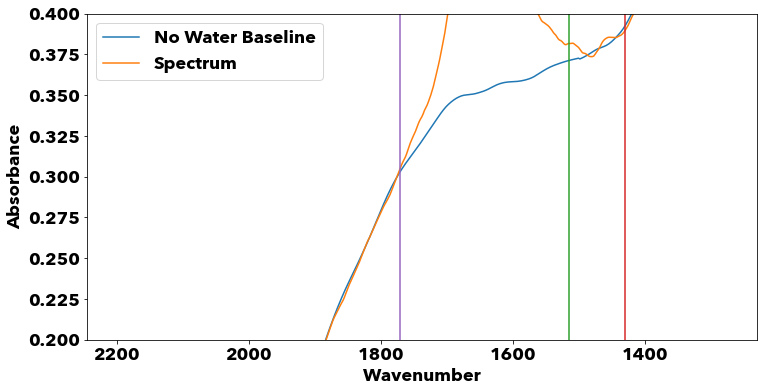

In [32]:
spec_idx = 14

fig, ax = plt.subplots(figsize=(12, 6))
H2O_init_range = H2O_Data_init[:, spec_idx][0] - H2O_Data_init[:, spec_idx][-1]
scale_data_No_H2O = No_H2O_baseline[spec_idx] / H2O_init_range
scale_H2O_Data = H2O_Data_init[:, spec_idx] / H2O_init_range

plt.plot(
    Wavenumber_full, scale_data_No_H2O - scale_H2O_Data.min(), label="No Water Baseline"
)
plt.plot(Wavenumber_full, scale_H2O_Data - scale_H2O_Data.min(), label="Spectrum")

plt.legend()
ax.invert_xaxis()
ax.legend()
ax.set_xlabel("Wavenumber")
ax.set_ylabel("Absorbance")

ax.set_ylim(0.2, 0.4)

plt.plot((1515, 1515), (0, 1))
plt.plot((1430, 1430), (0, 1))
plt.plot((1770, 1770), (0, 1))
# Exclude 2, 6, 23, 29, 30, 33, 36, 37

/var/folders/3h/h9xj5mr15rnf5gx1cwr12h280000gn/T/ipykernel_1462/2577420854.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12, 6))


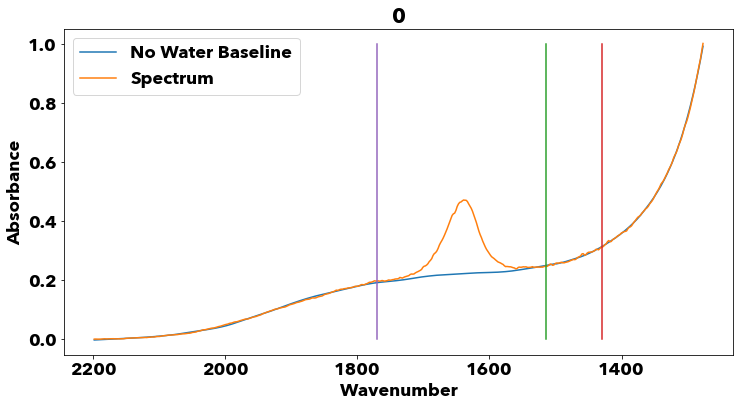

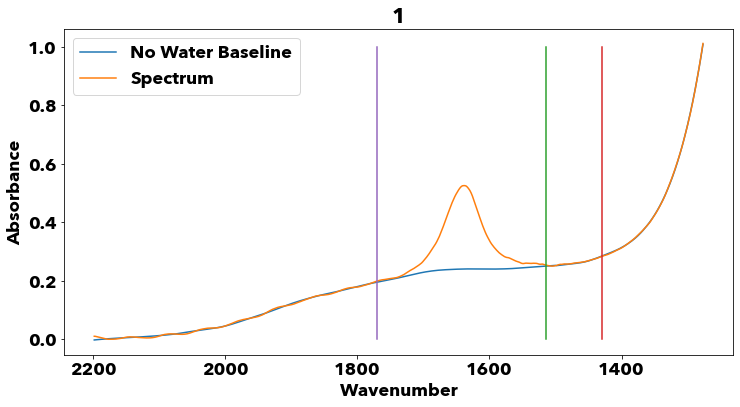

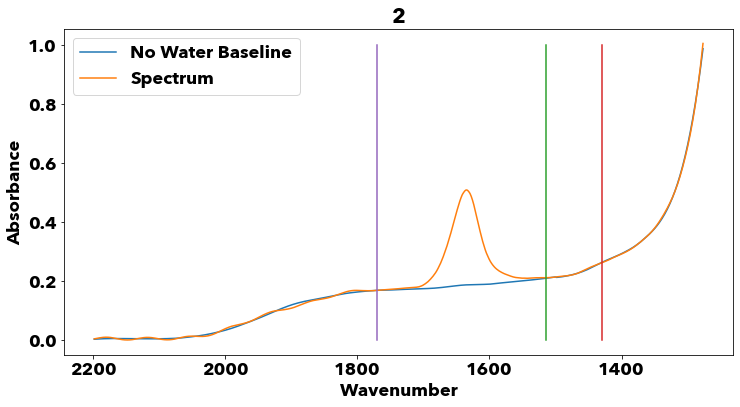

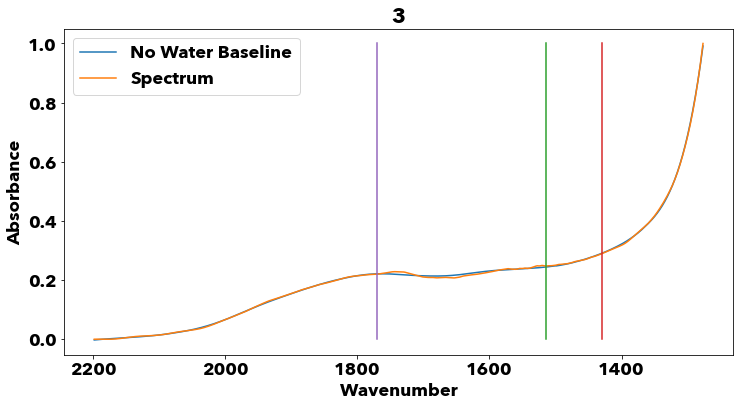

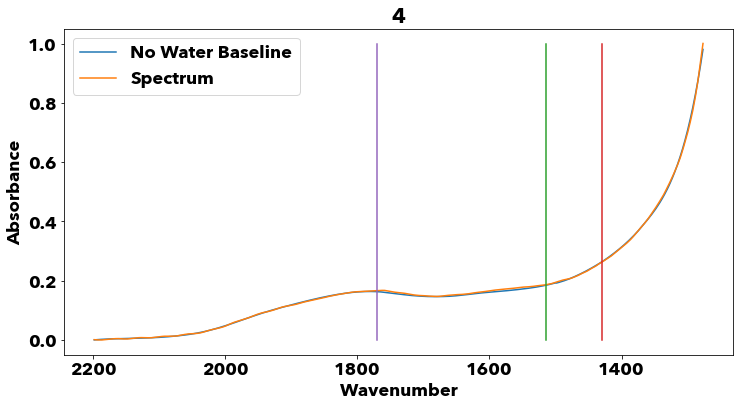

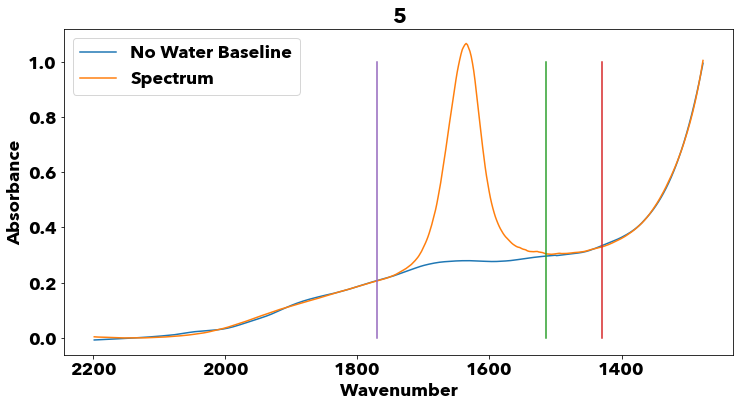

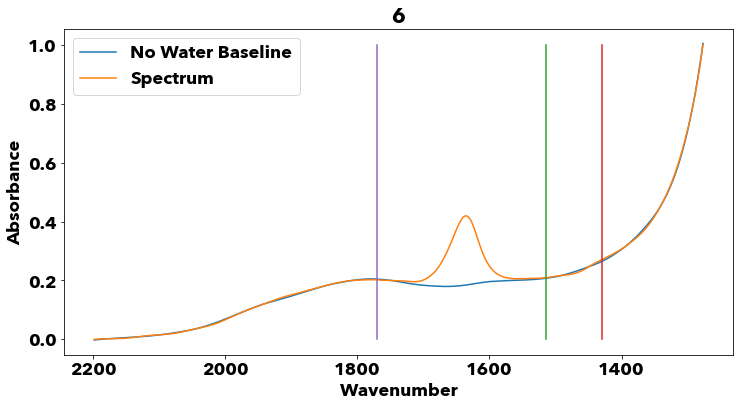

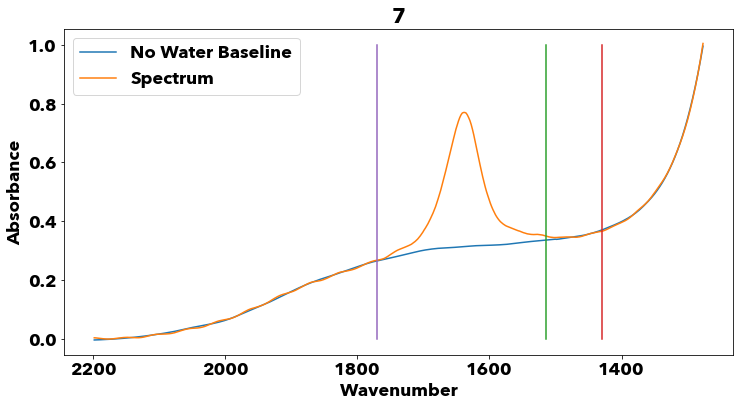

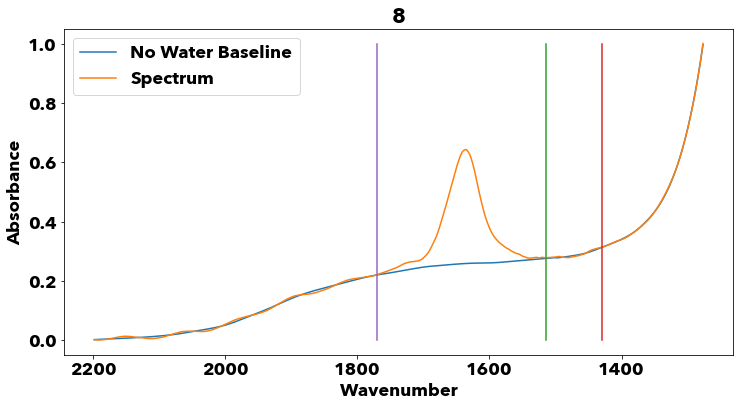

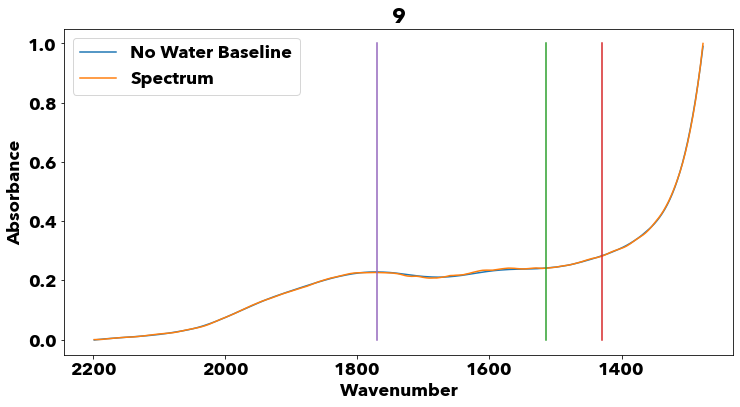

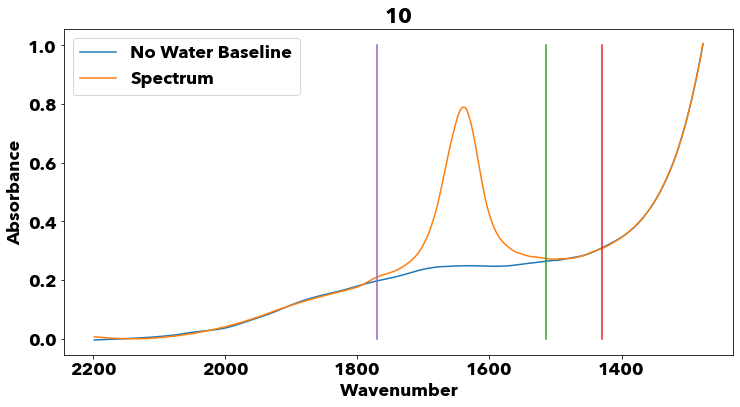

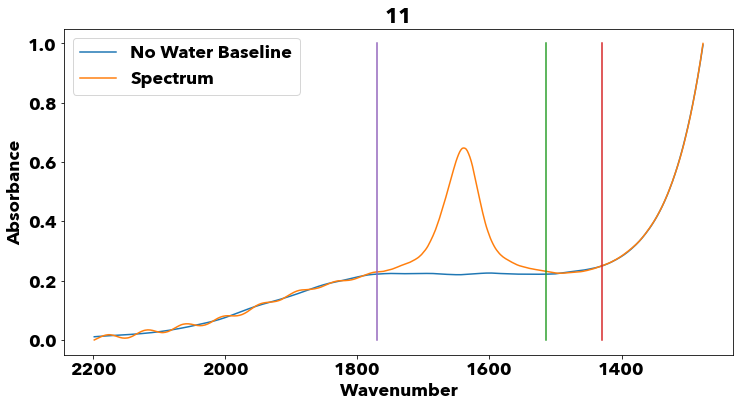

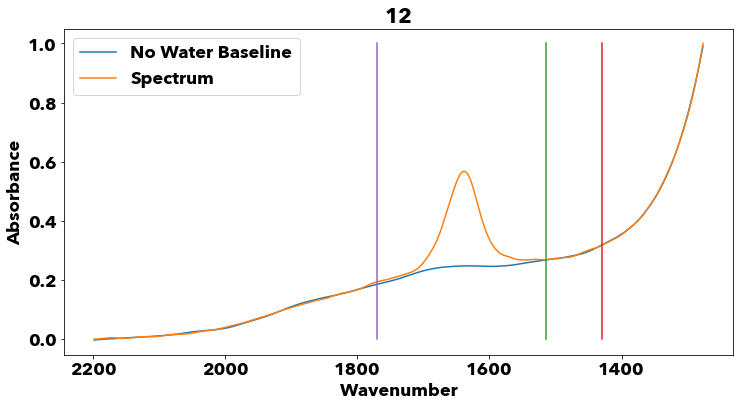

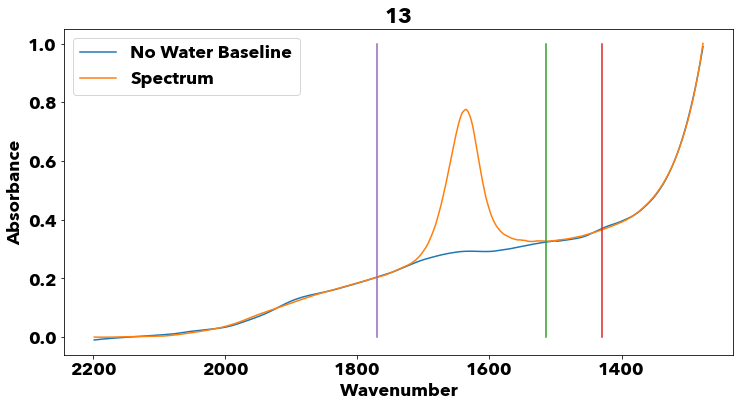

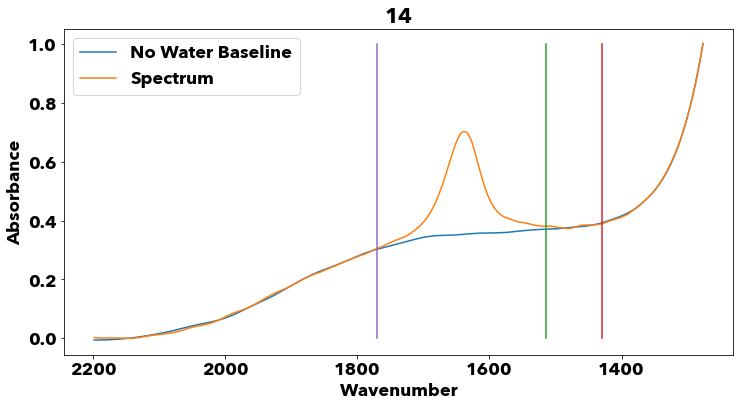

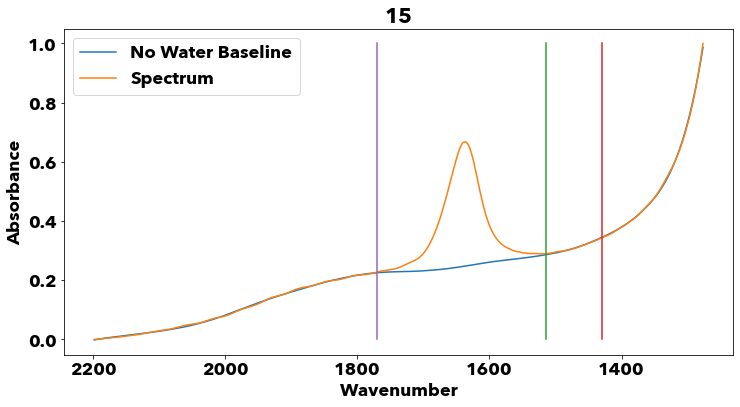

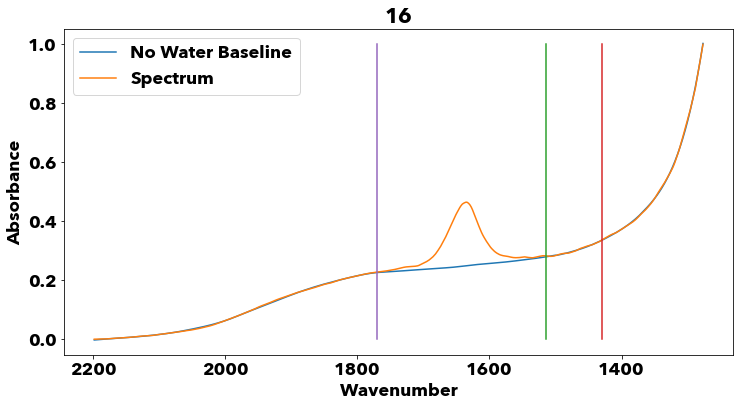

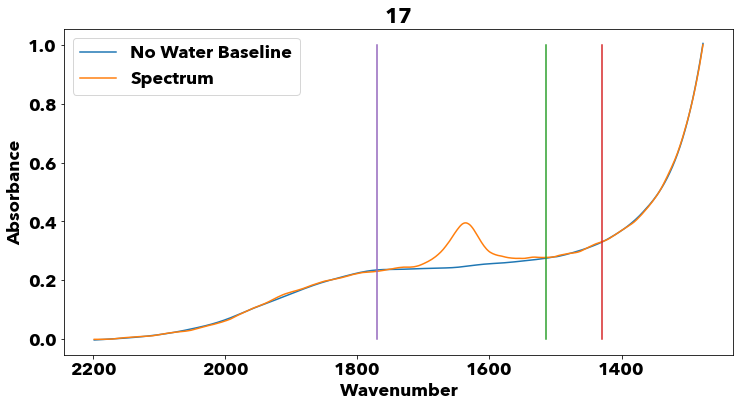

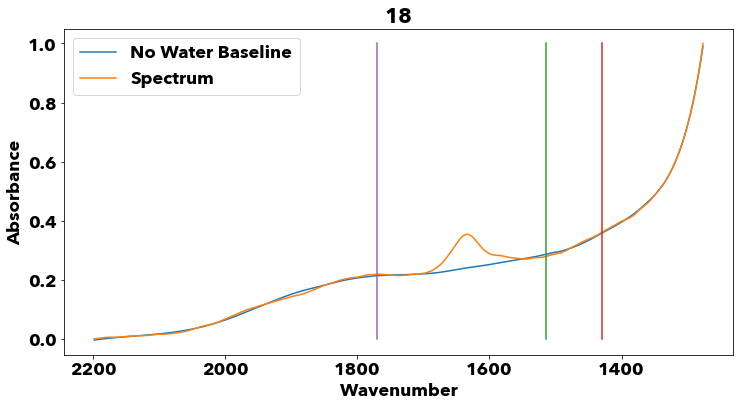

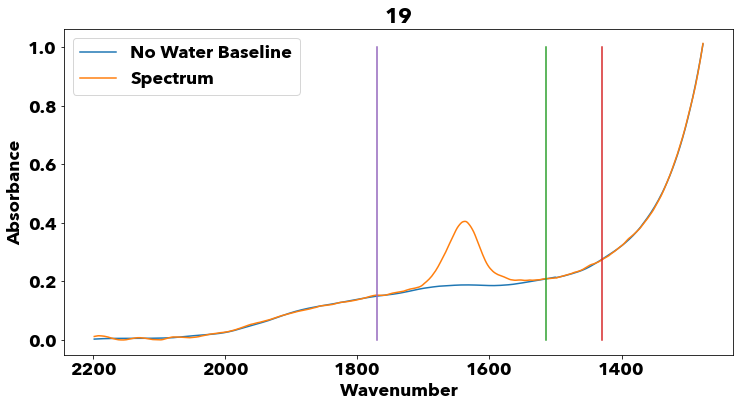

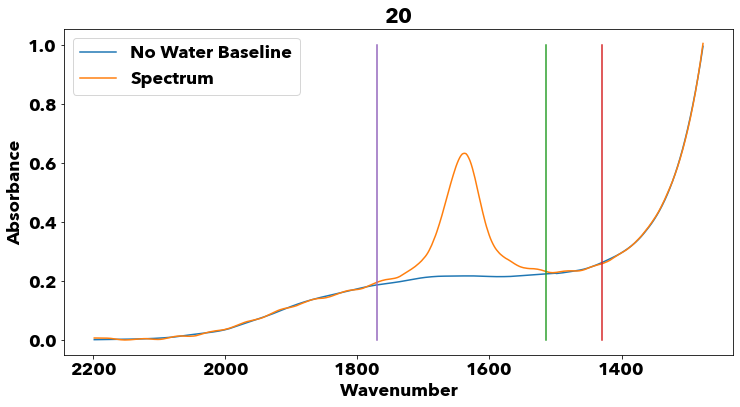

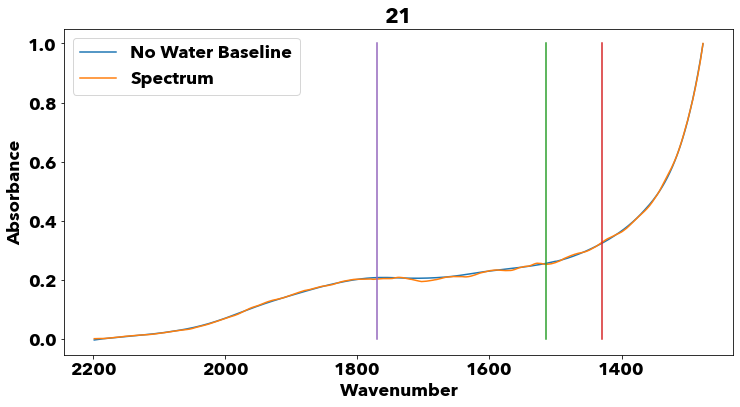

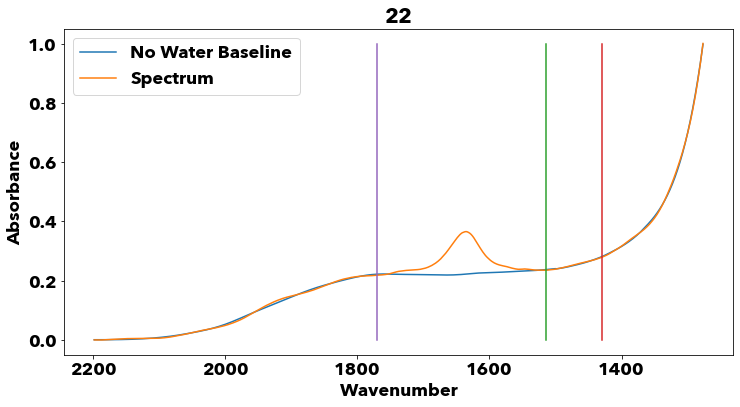

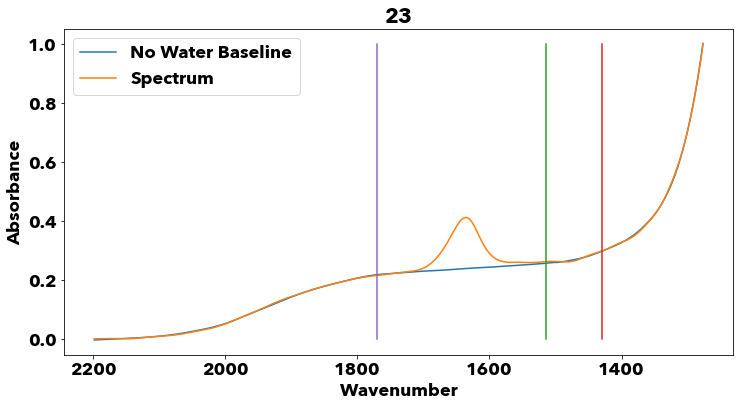

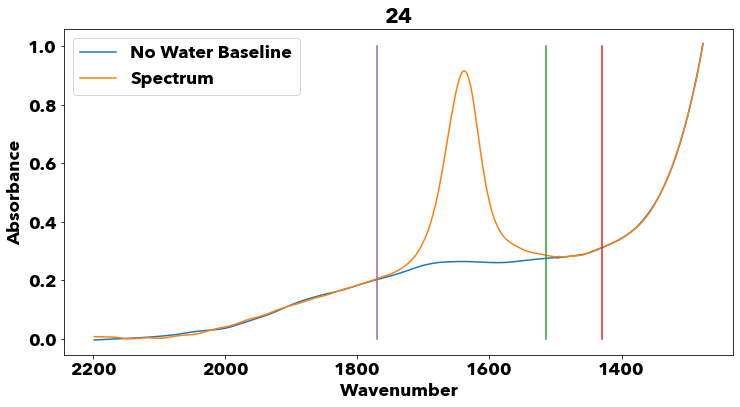

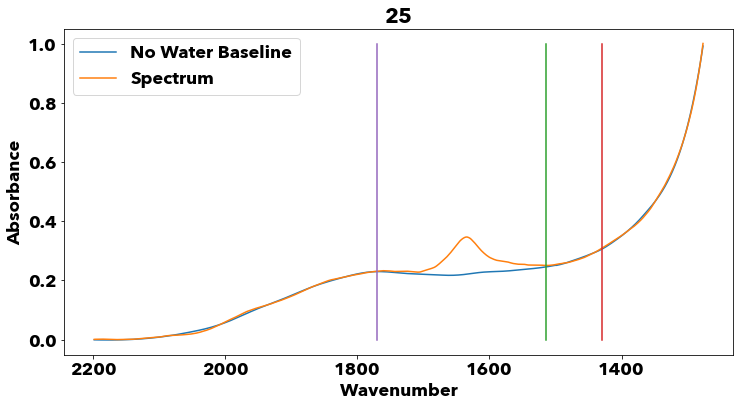

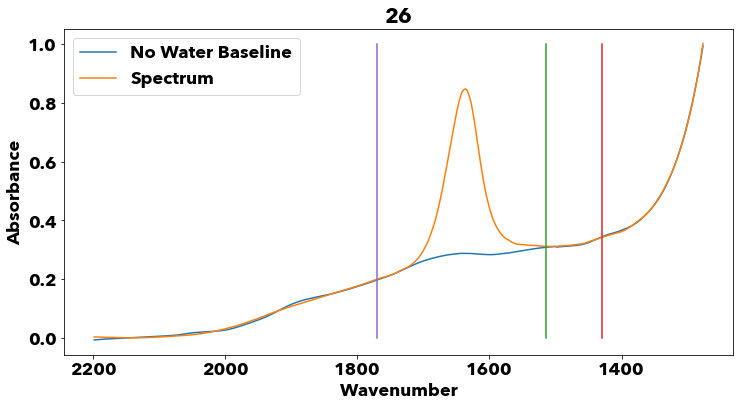

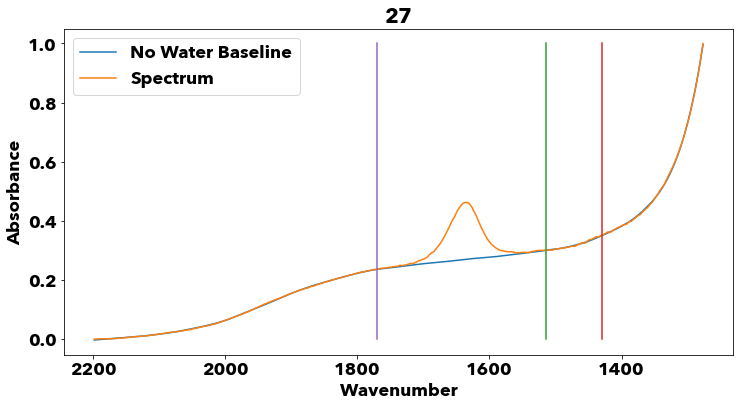

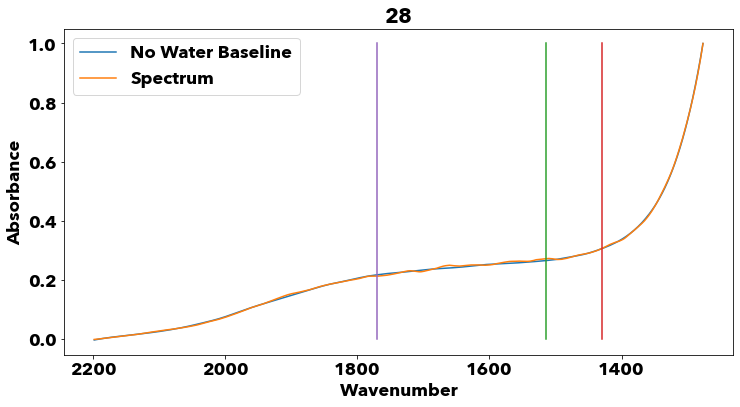

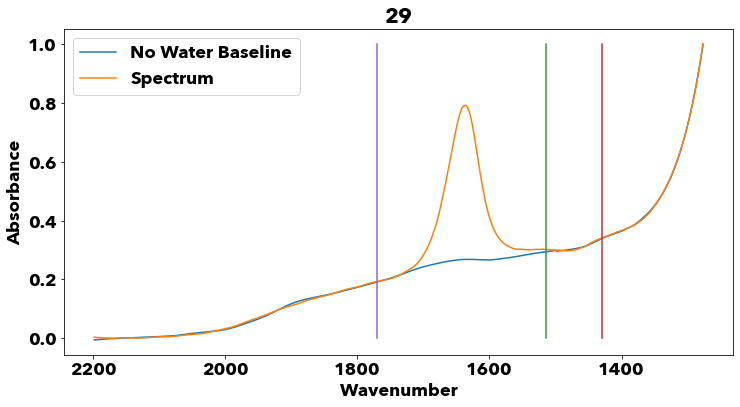

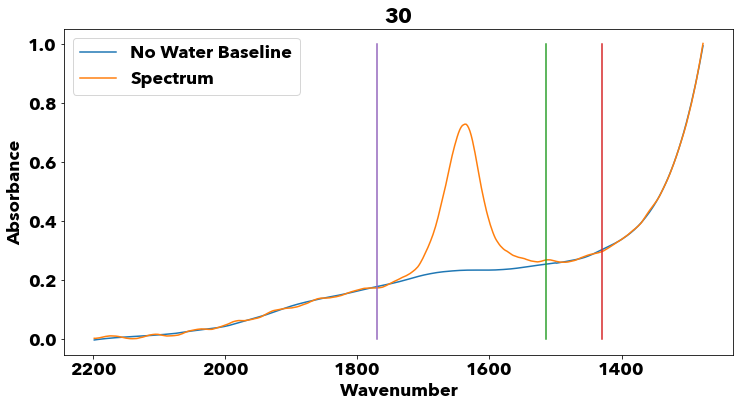

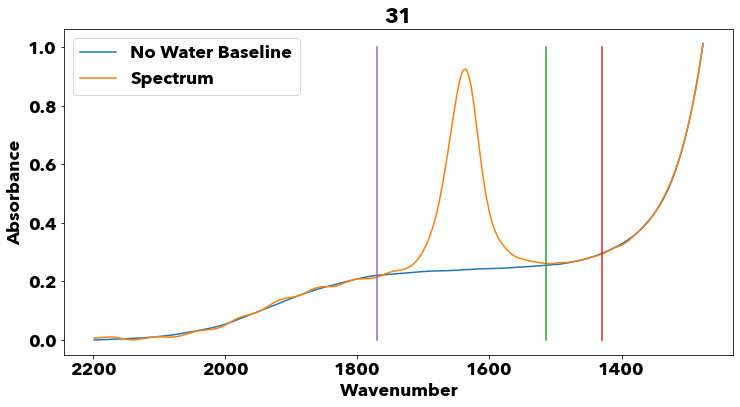

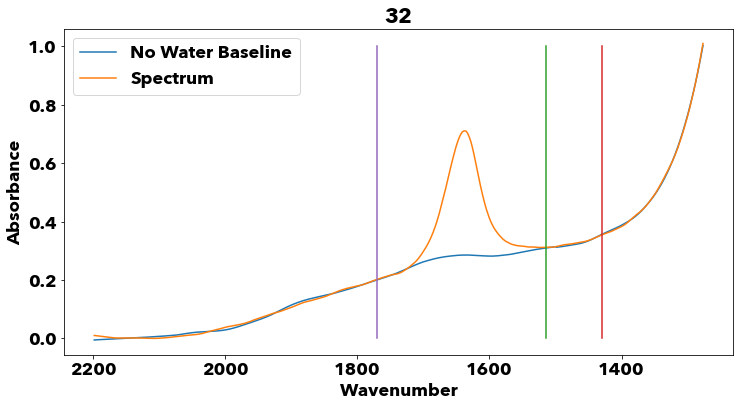

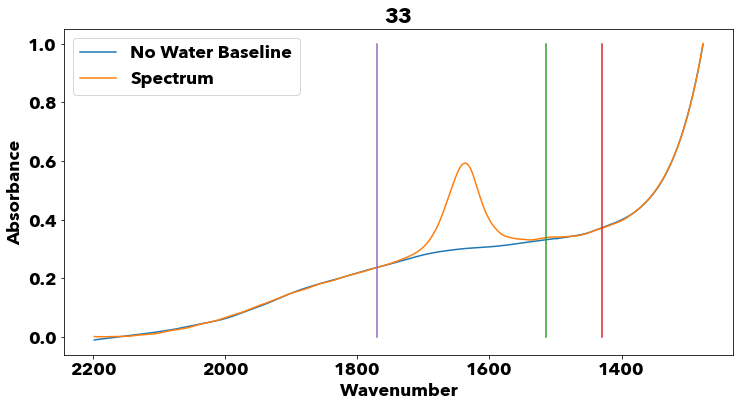

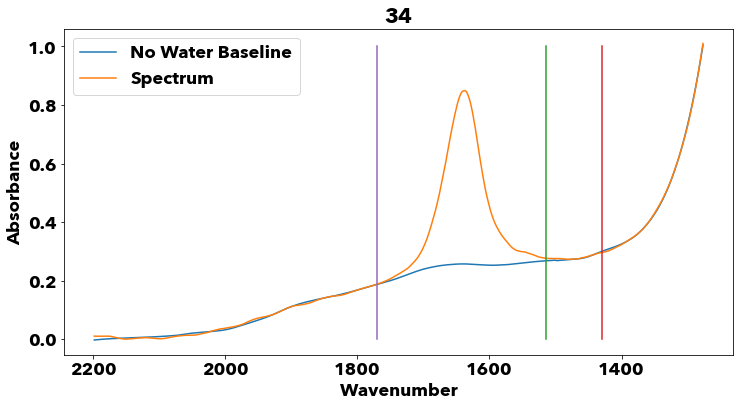

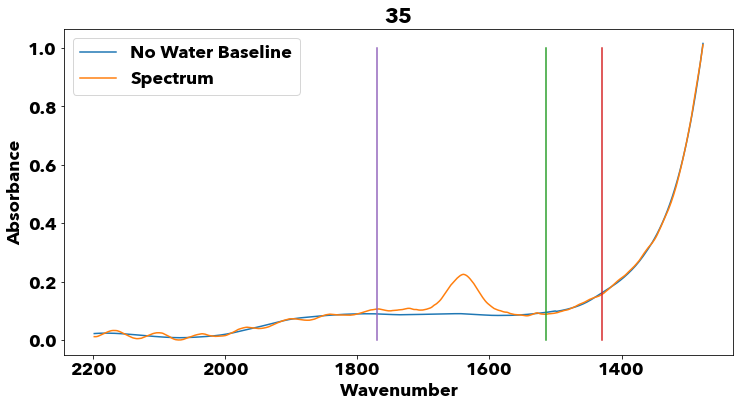

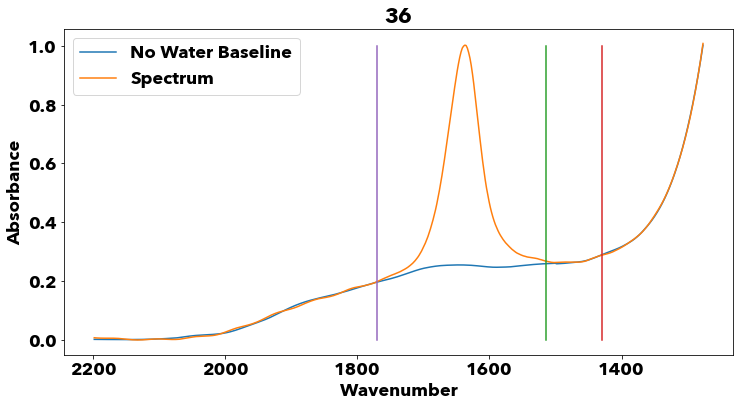

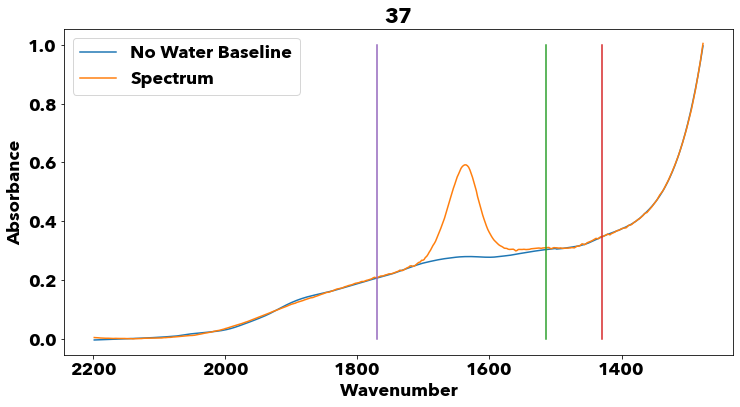

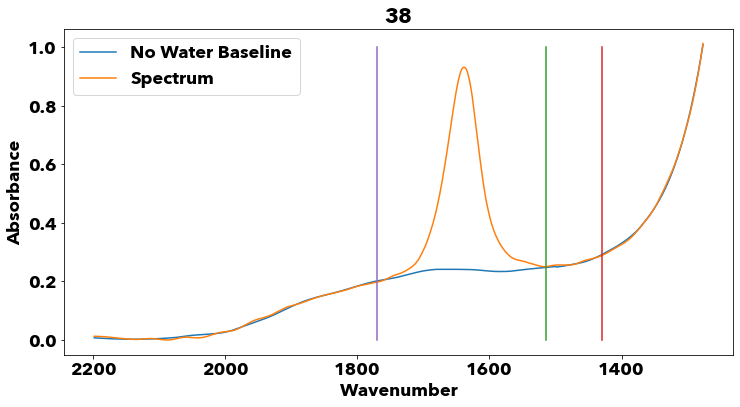

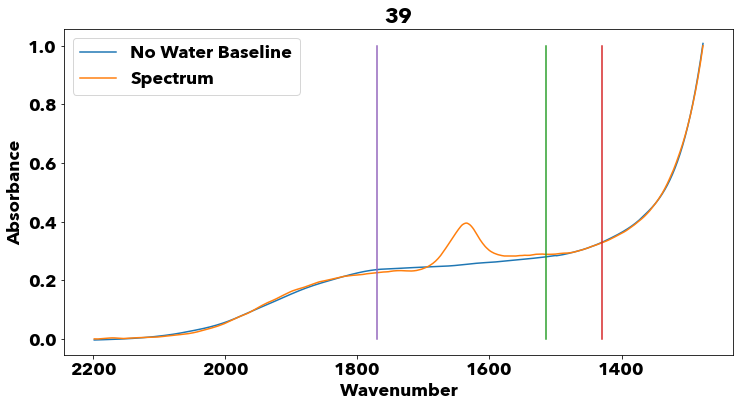

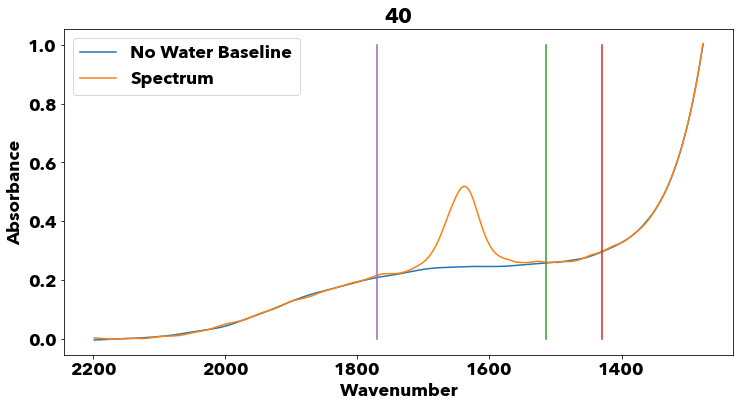

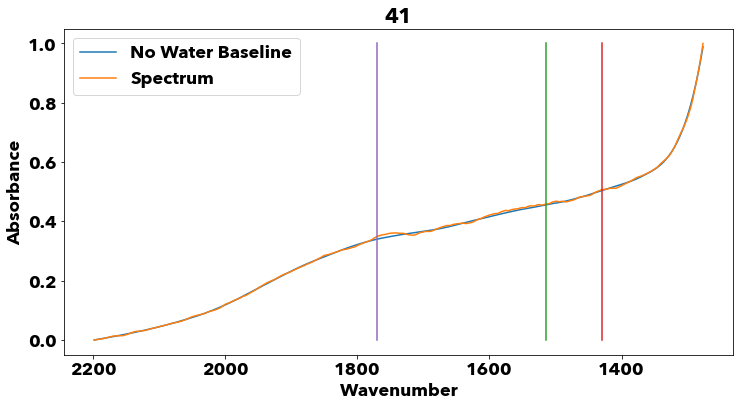

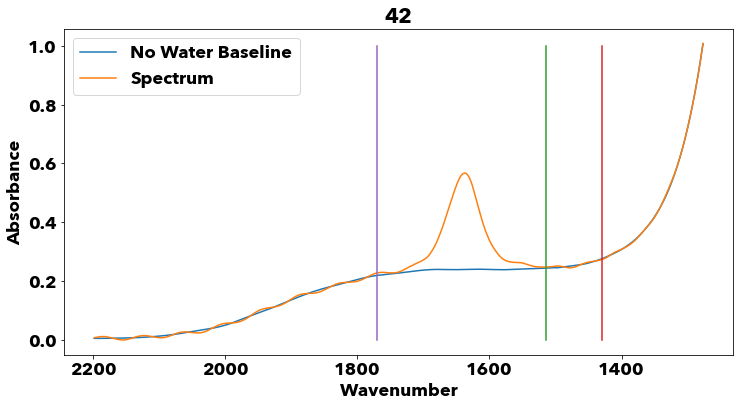

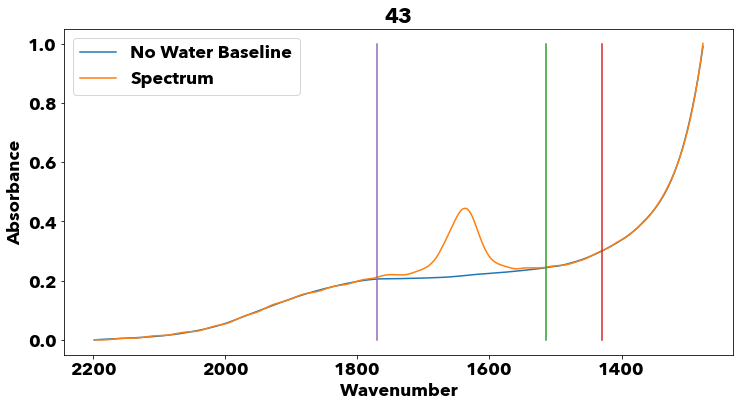

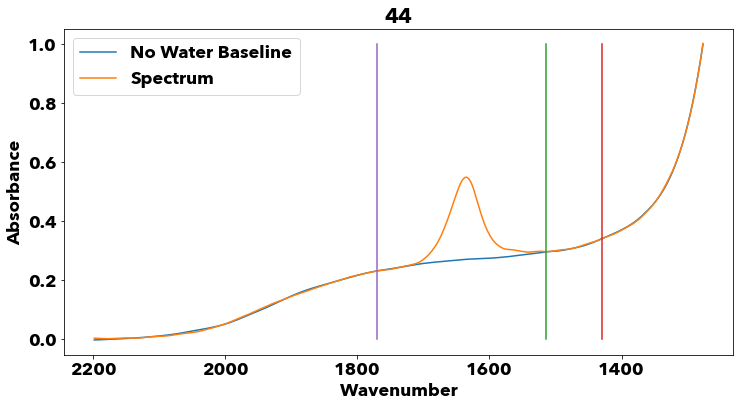

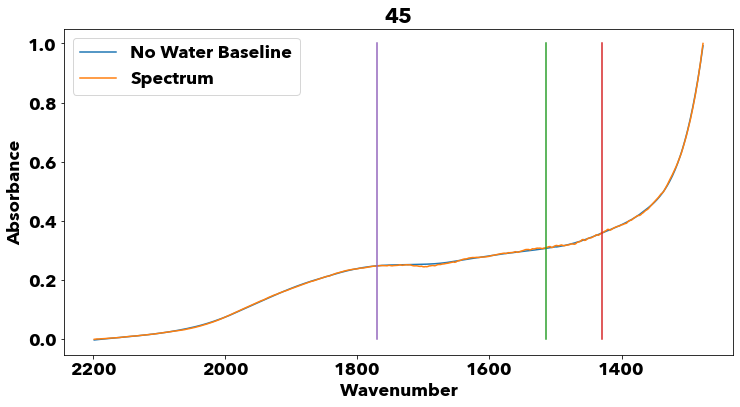

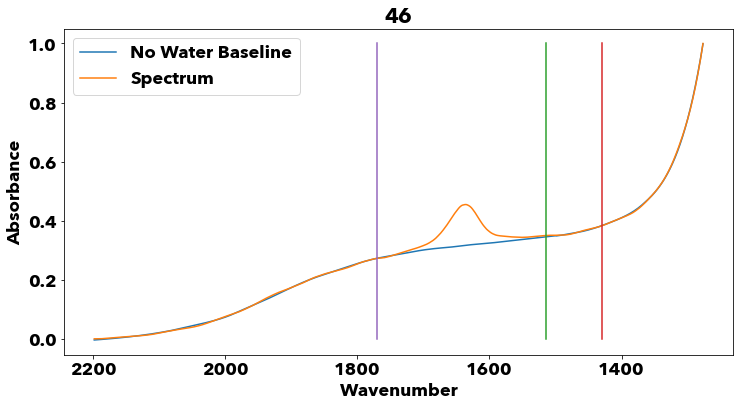

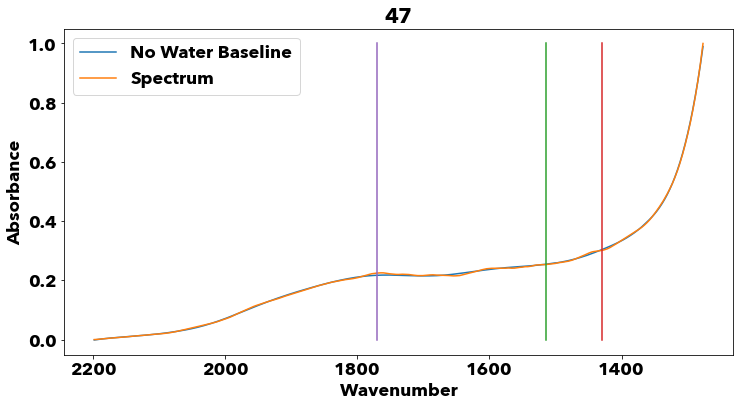

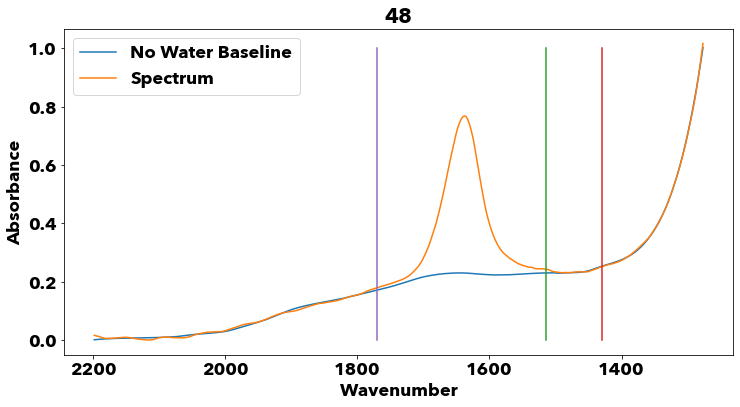

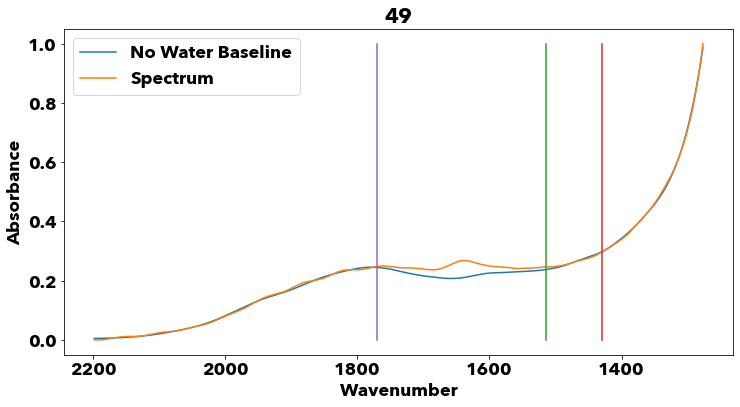

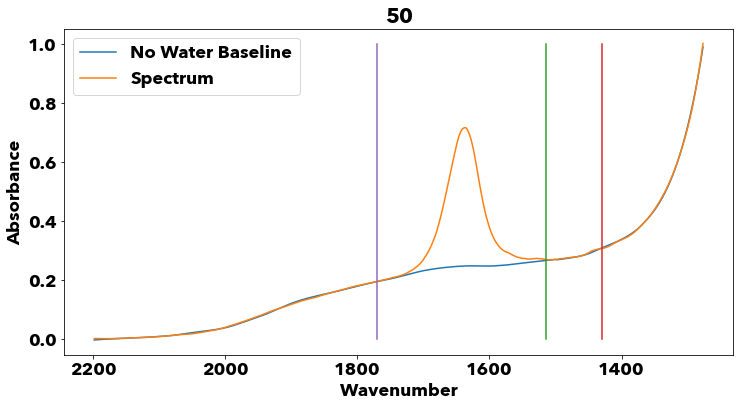

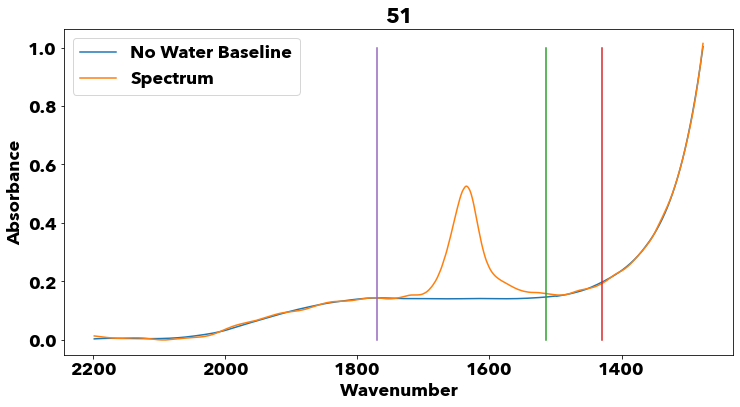

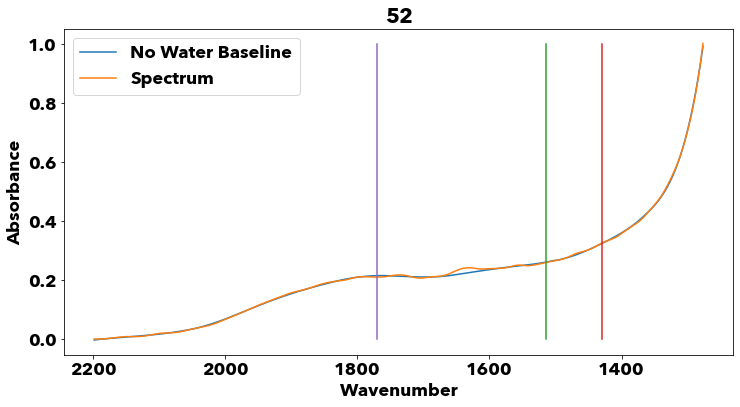

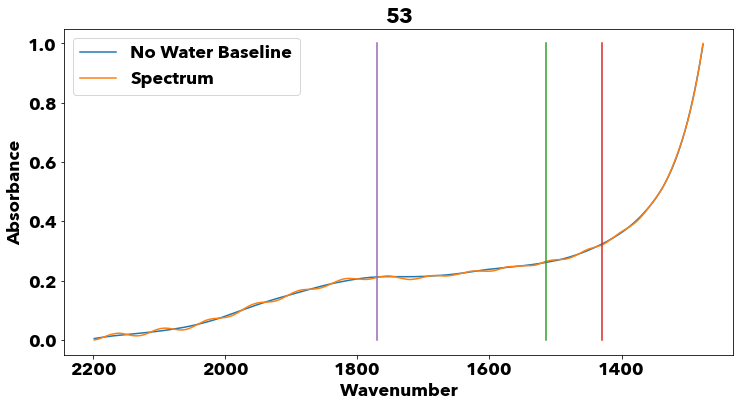

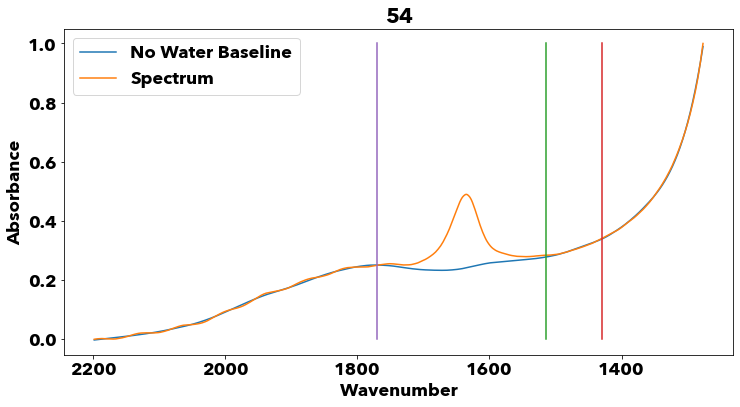

In [33]:
# Decisions For selection the best water only peaks 5/12
# Good: 0,
# Bad: 2, 3
# Maybe:1, 6?, 7,
# Notes
# look at 14, 35

plt.close("all")
# spec_idx = 1
for spec_idx in range(len(No_H2O_baseline)):
    fig, ax = plt.subplots(figsize=(12, 6))
    H2O_init_range = H2O_Data_init[:, spec_idx][0] - H2O_Data_init[:, spec_idx][-1]
    scale_data_No_H2O = No_H2O_baseline[spec_idx] / H2O_init_range
    scale_H2O_Data = H2O_Data_init[:, spec_idx] / H2O_init_range

    plt.plot(
        Wavenumber_full,
        scale_data_No_H2O - scale_H2O_Data.min(),
        label="No Water Baseline",
    )

    plt.plot(Wavenumber_full, scale_H2O_Data - scale_H2O_Data.min(), label="Spectrum")

    plt.legend()
    ax.invert_xaxis()
    ax.legend()
    plt.title(str(spec_idx))

    ax.set_xlabel("Wavenumber")
    ax.set_ylabel("Absorbance")
    # ax.set_xlim(1800,1250)
    # ax.set_xlim(1750,1500)

    # ax.set_ylim(0.1, 0.4)

    plt.plot((1515, 1515), (0, 1))
    plt.plot((1430, 1430), (0, 1))
    plt.plot((1770, 1770), (0, 1))

In [40]:

No_H2O_baseline_df = pd.DataFrame(
    np.array(No_H2O_baseline)[:, :, 0].T,
    index=Wavenumber_full,
    columns=H2O_frame_select.columns,
)

H2O_Peaks = H2O_frame_select - No_H2O_baseline_df

H2O_select_smooth = pd.DataFrame(
    smoothing_protocol(H2O_frame_select.values),
    index=Wavenumber,
    columns=H2O_frame_select.columns,
)

# TODO stitch at multiple points at repeat this to make it smooth.
wn_stitch_low = 1451
wn_stitch_high = 1820

# Apply smooth junction. Maybe expand and reappend a wider series
cutout = No_H2O_baseline_df[wn_stitch_low:wn_stitch_high]

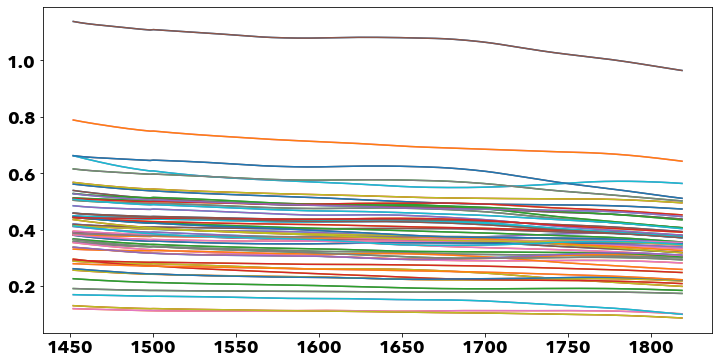

In [35]:
# smooth_cutout = np.apply_along_axis(savgol_filter,0,cutout, smooth_width = 31, poly_order = 3)

# smooth_cutout_df = pd.DataFrame(cutout, index =cutout.index, columns= cutout.columns)
smooth_cutout_df = cutout
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(smooth_cutout_df.index, smooth_cutout_df)
plt.plot(cutout)

In [36]:
# Stitching together data where peaks have been removed


offset_H2O_frame = (
    H2O_select_smooth.loc[wn_stitch_high - 2 : wn_stitch_high].values
    - H2O_select_smooth.loc[wn_stitch_low : wn_stitch_low + 2].values
)

offset_smooth_cutout = (
    smooth_cutout_df.loc[wn_stitch_high - 2 : wn_stitch_high].values
    - smooth_cutout_df.loc[wn_stitch_low : wn_stitch_low + 2].values
)

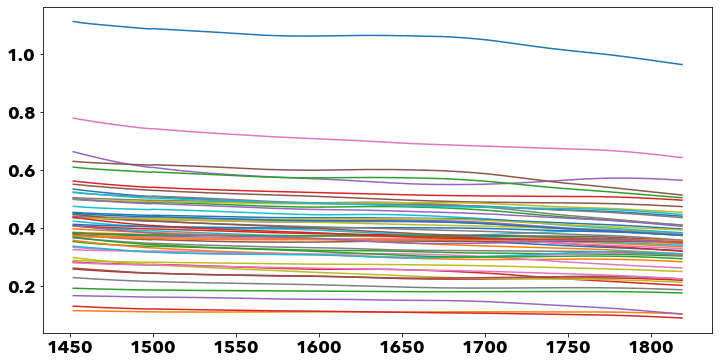

In [37]:
Scaled_data_cut = smooth_cutout_df * (
    offset_H2O_frame / offset_smooth_cutout
)  # Strech segment slightly to line up with edges being cut

offset_1500 = (
    H2O_select_smooth.loc[wn_stitch_low : wn_stitch_low + 2].values
    - Scaled_data_cut.loc[wn_stitch_low : wn_stitch_low + 2].values
)

offset_1800 = (
    H2O_select_smooth.loc[wn_stitch_high - 2 : wn_stitch_high].values
    - Scaled_data_cut.loc[wn_stitch_high - 2 : wn_stitch_high].values
)

# slope = (offset_1800.values - offset_1500.values)/ (wn_cut_high-wn_cut_low)
# cutout_tilt = np.tile(np.arange(0, len(cutout.index)) - len(cutout.index)/2,(len(cutout.columns),1))

# stitch_adjust = pd.DataFrame(np.multiply(slope, cutout_tilt.T ) + offset_1500.values, index = cutout.index, columns = cutout.columns)

# cut_adjusted = smooth_cutout_df + stitch_adjust
cut_adjusted = Scaled_data_cut + offset_1800

# I need to stretch not tilt!!!

fig, ax = plt.subplots(figsize=(12, 6))
# plt.plot(cut_adjusted)
plt.plot(cut_adjusted)

/var/folders/3h/h9xj5mr15rnf5gx1cwr12h280000gn/T/ipykernel_1462/9091773.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Peaks_removed_full_DF = H2O_select_smooth.drop(


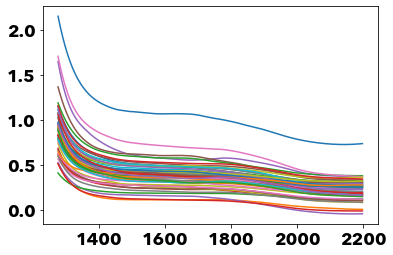

In [38]:

# TODO Repeat stitching on 2 sets of data cut at different points and average
# Smooth Original data before stitch
Peaks_removed_full_DF = H2O_select_smooth.drop(
    H2O_select_smooth.loc[wn_stitch_low:wn_stitch_high].index
).append(
    cut_adjusted,
)
Peaks_removed_full_DF.sort_index(inplace=True)
plt.plot(Peaks_removed_full_DF)

Peaks_removed_full_DF.to_csv("CO2_free_baselines_Water_removed_5-19-21.csv")


/var/folders/3h/h9xj5mr15rnf5gx1cwr12h280000gn/T/ipykernel_1462/424139317.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12, 6))


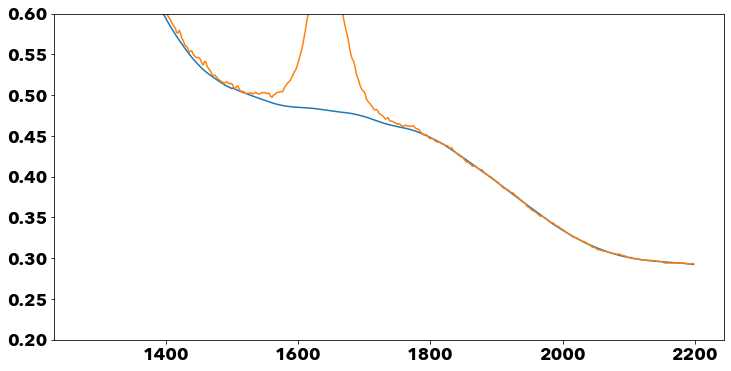

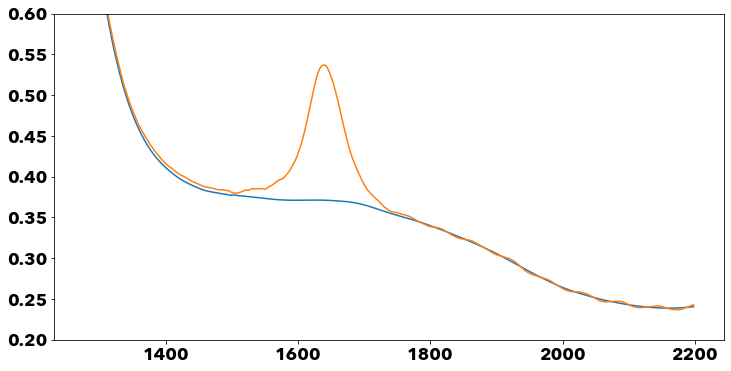

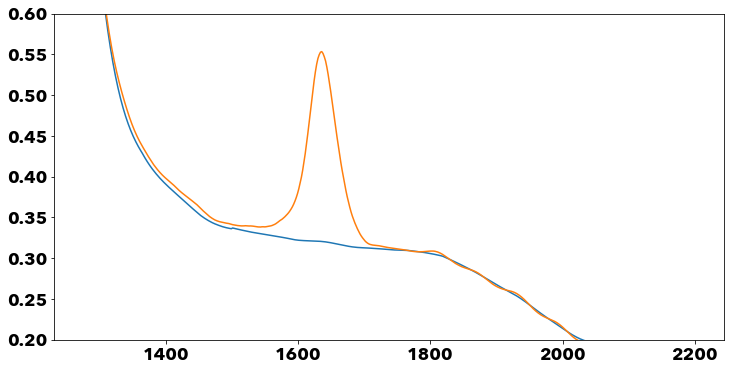

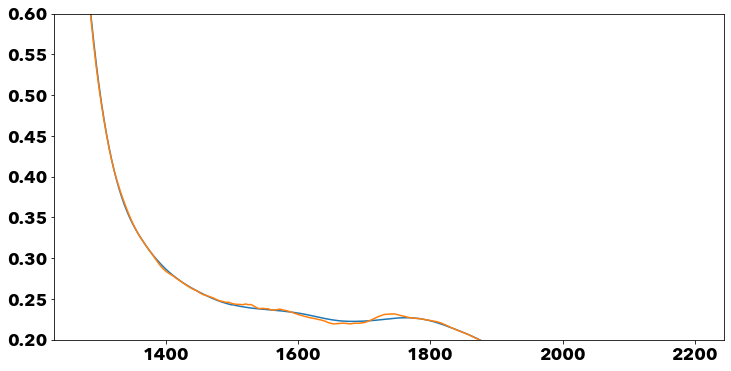

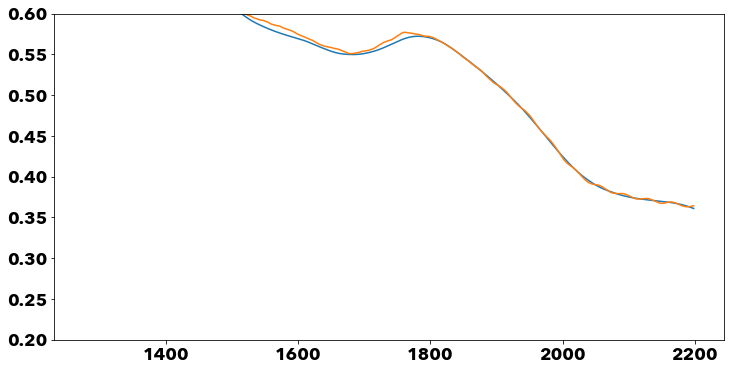

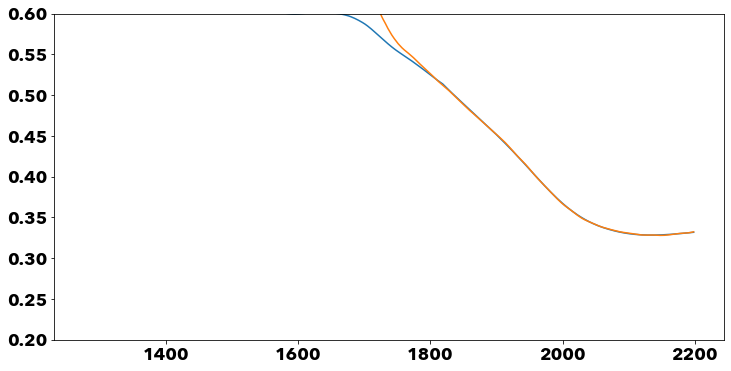

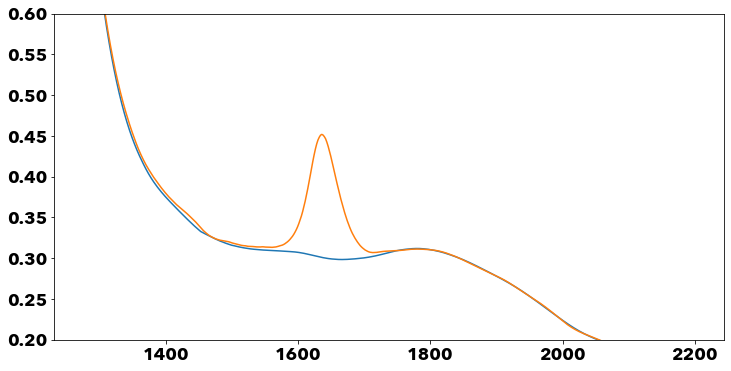

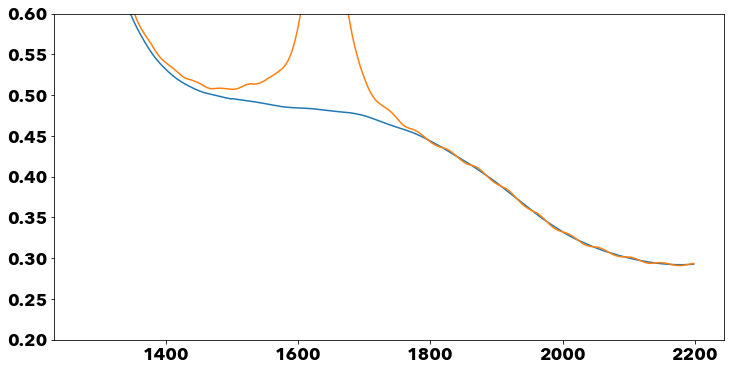

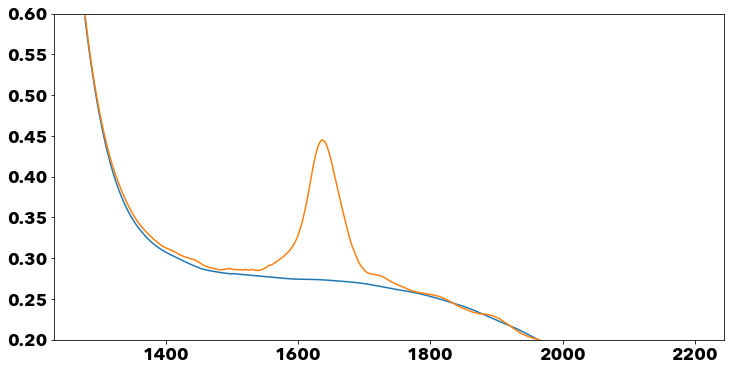

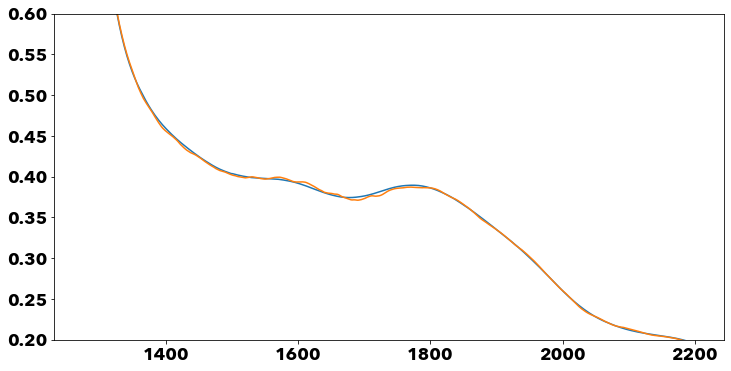

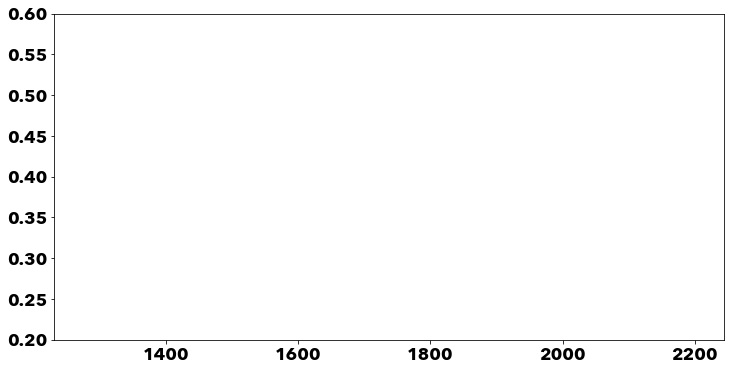

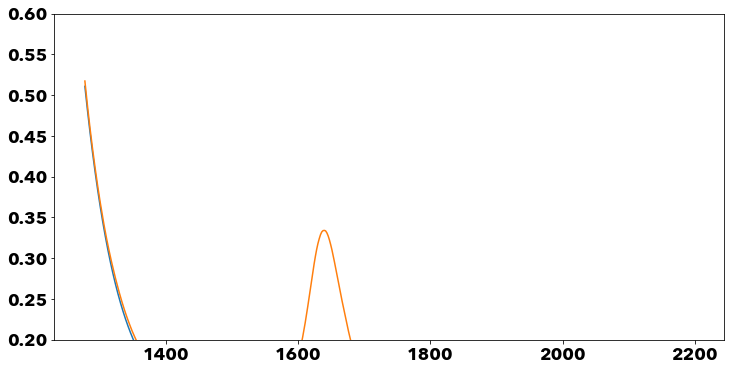

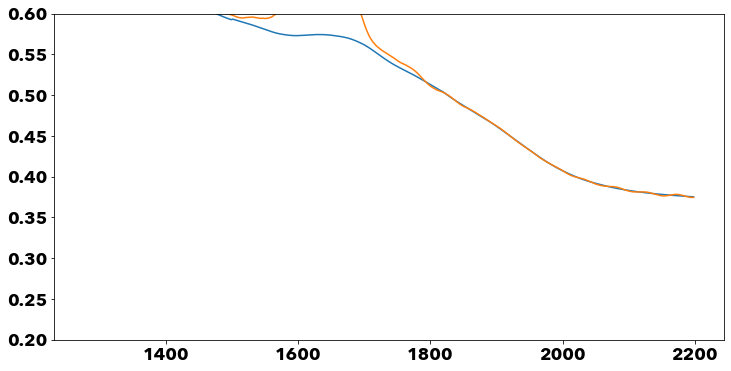

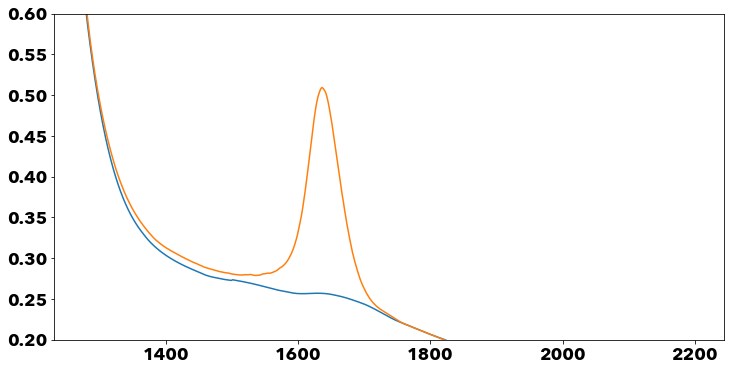

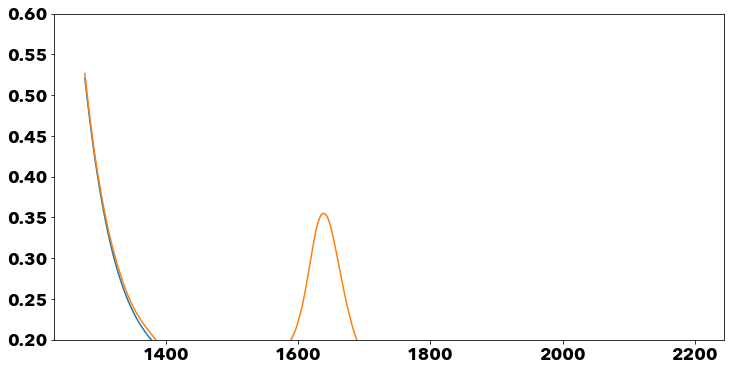

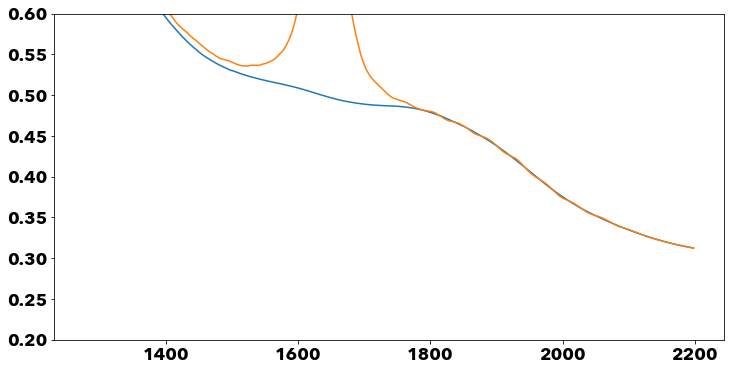

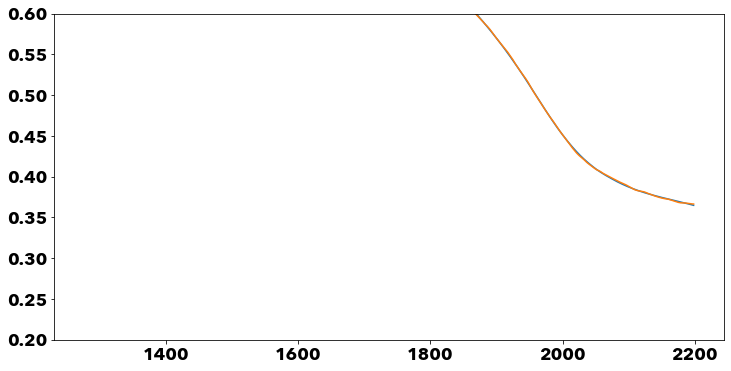

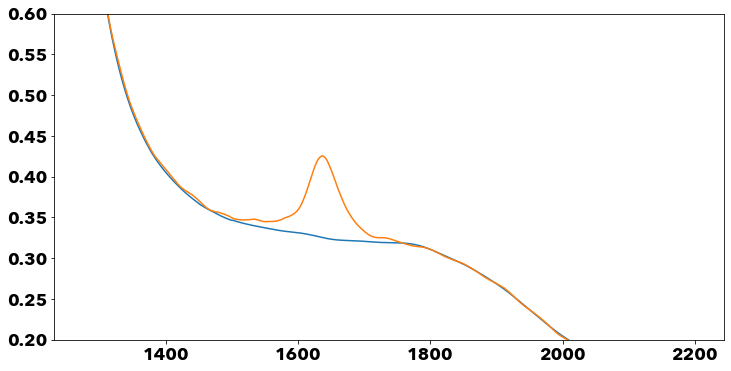

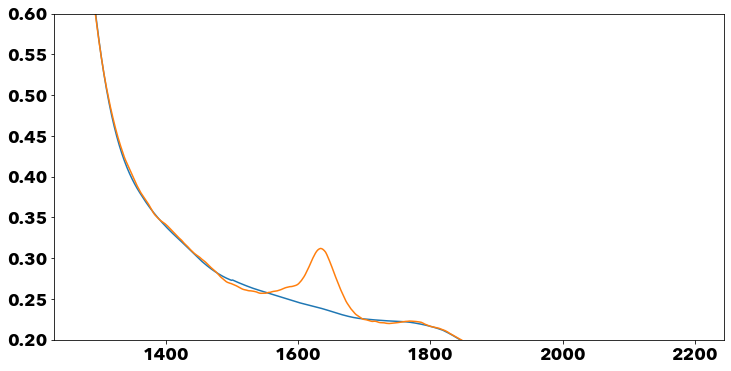

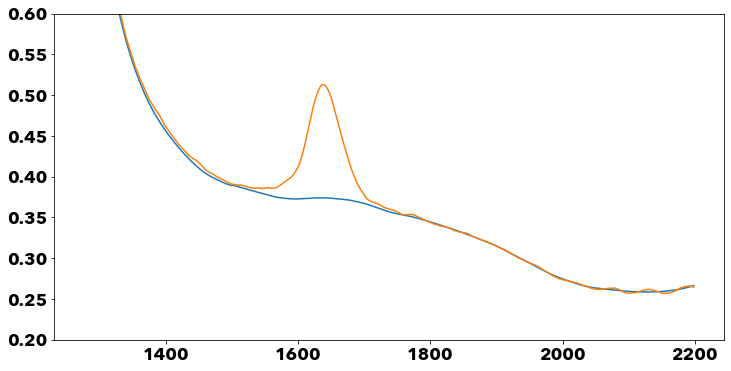

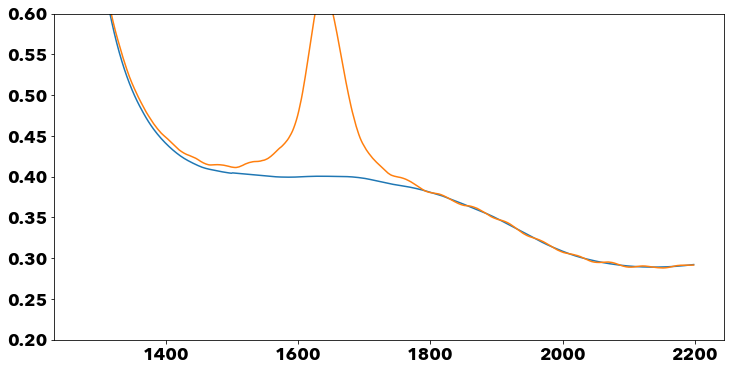

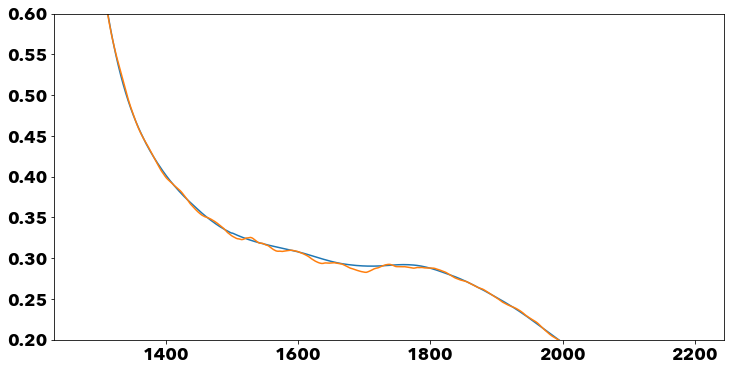

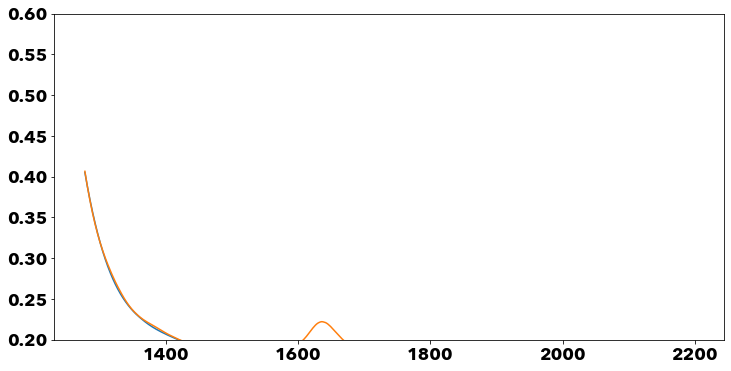

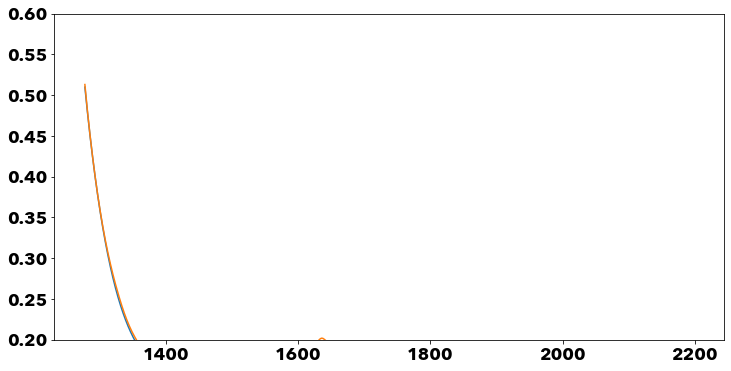

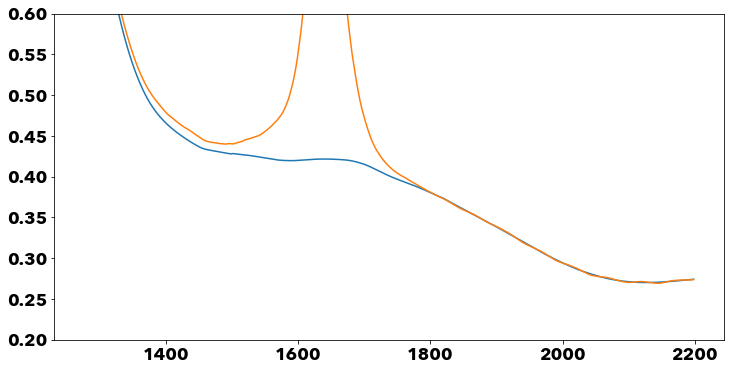

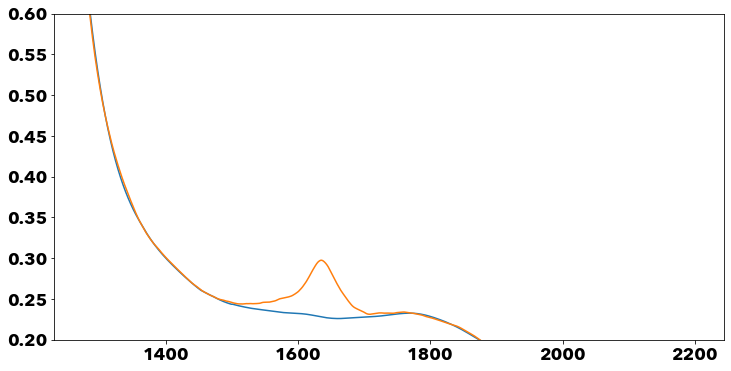

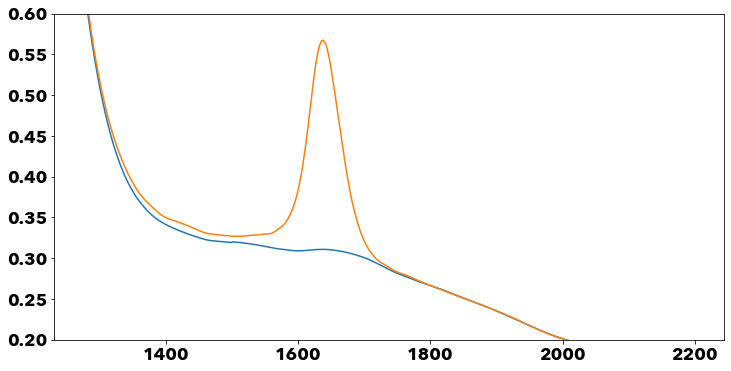

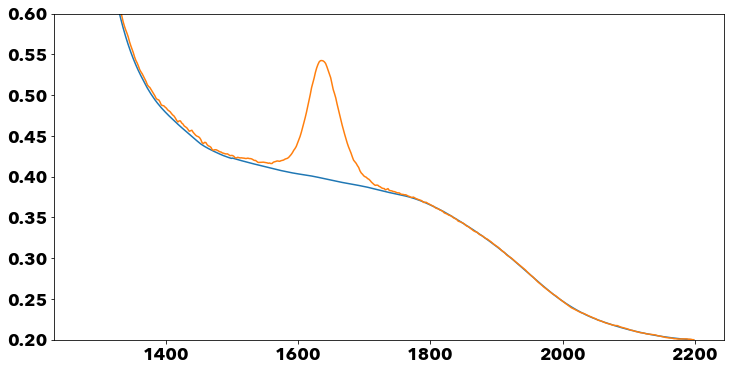

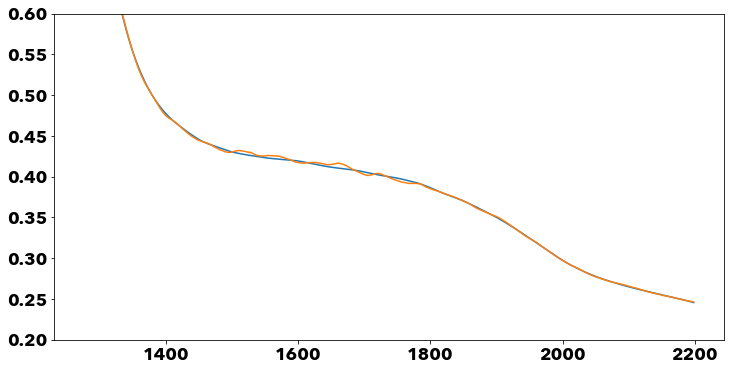

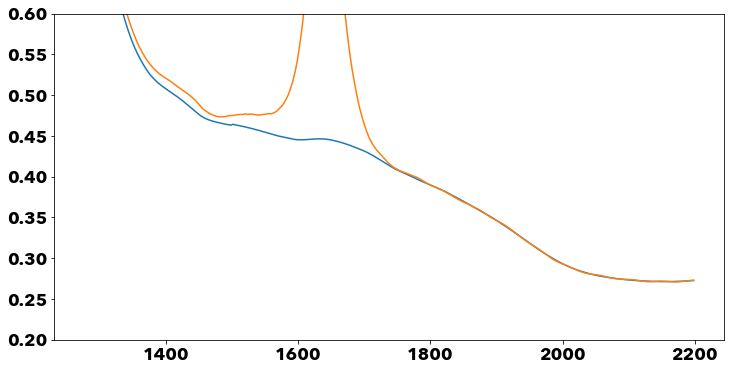

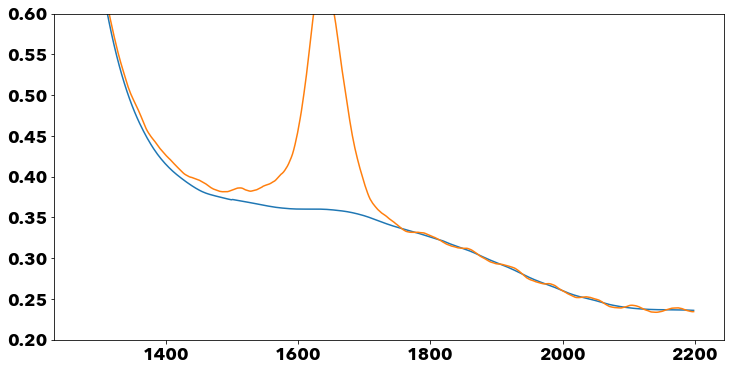

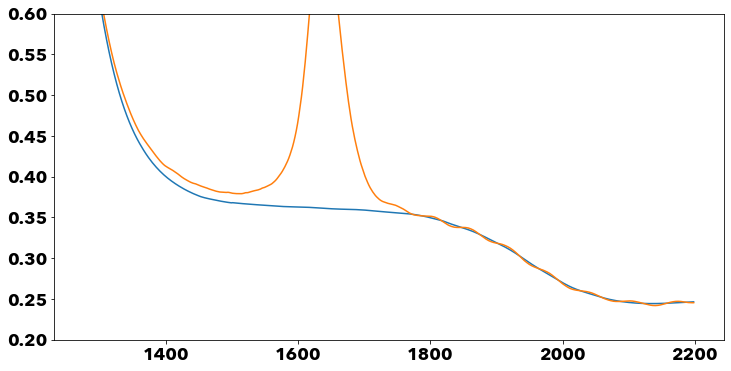

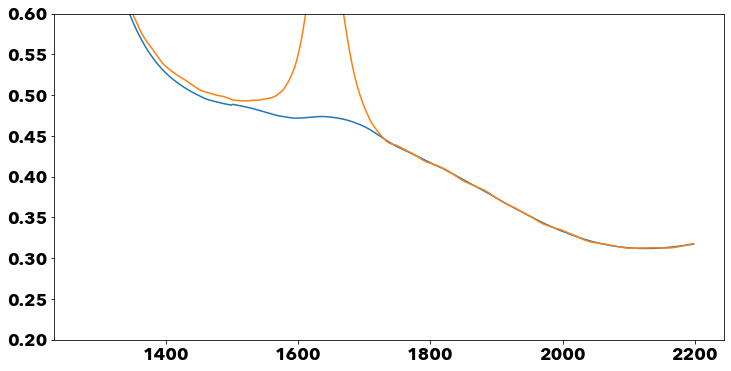

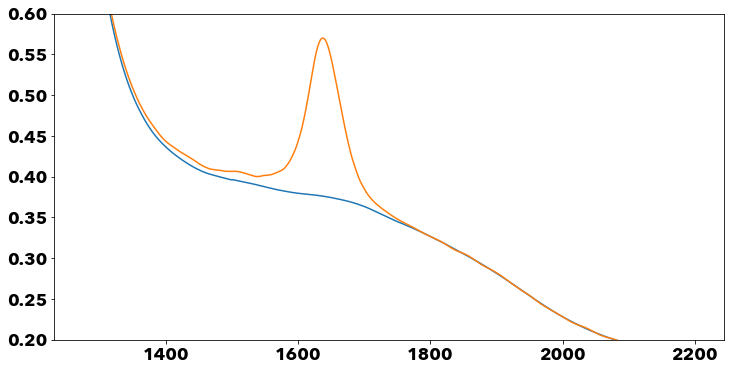

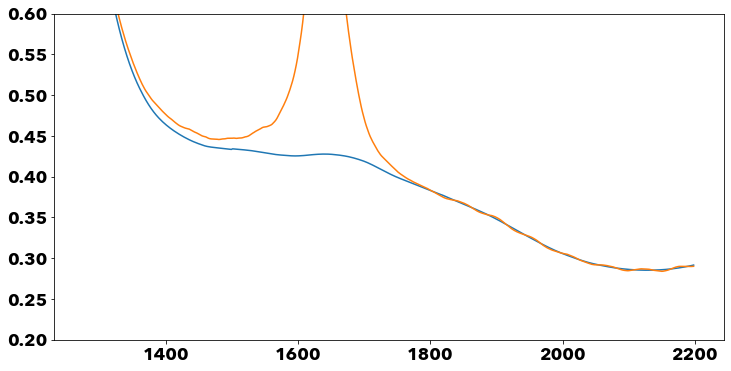

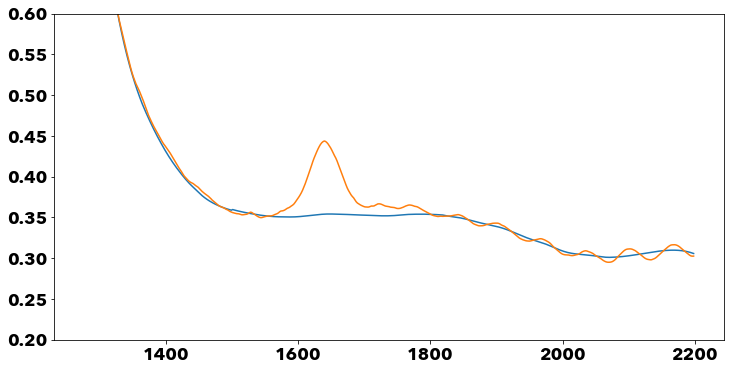

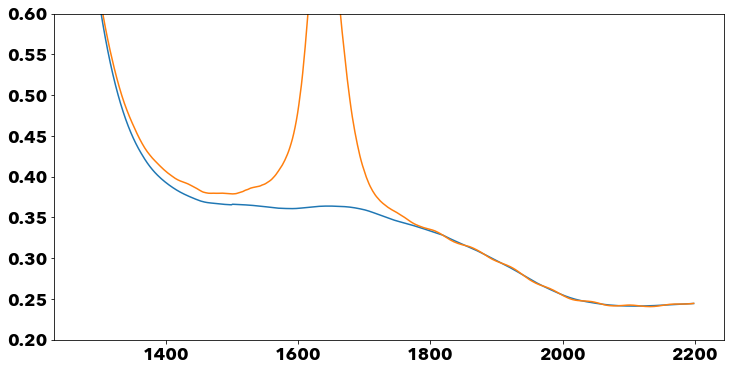

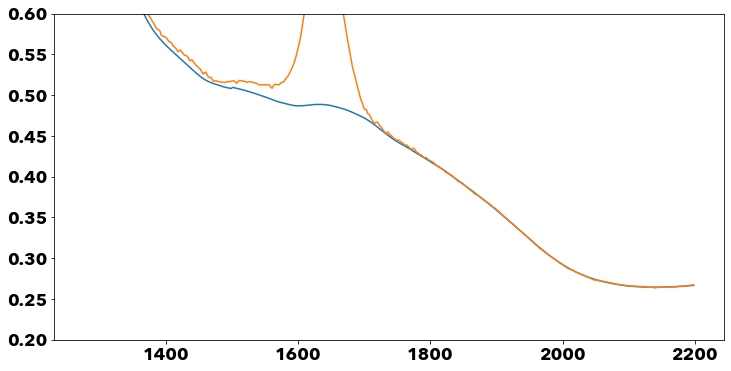

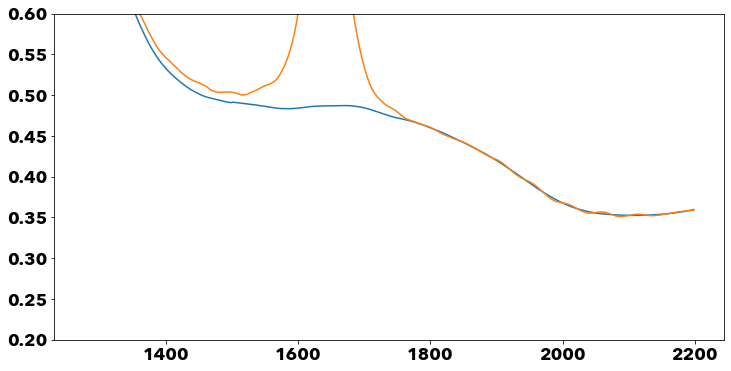

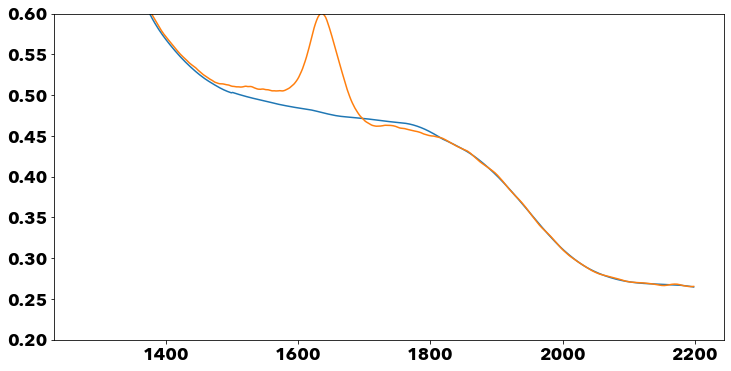

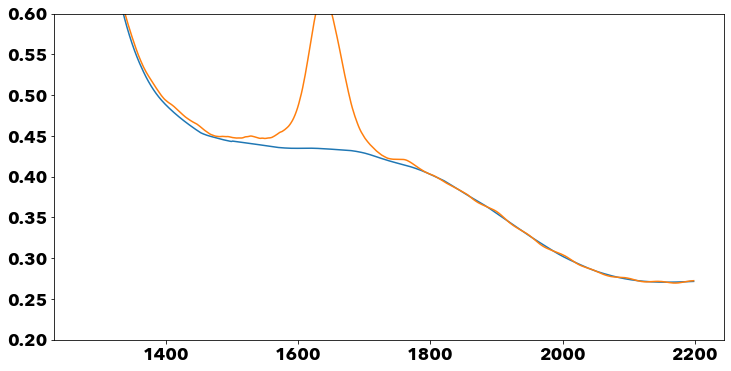

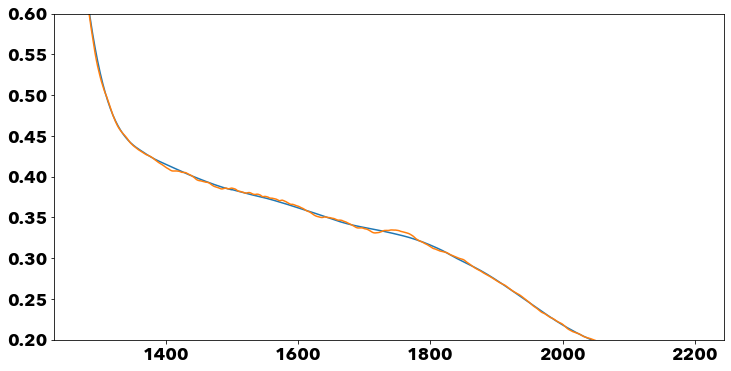

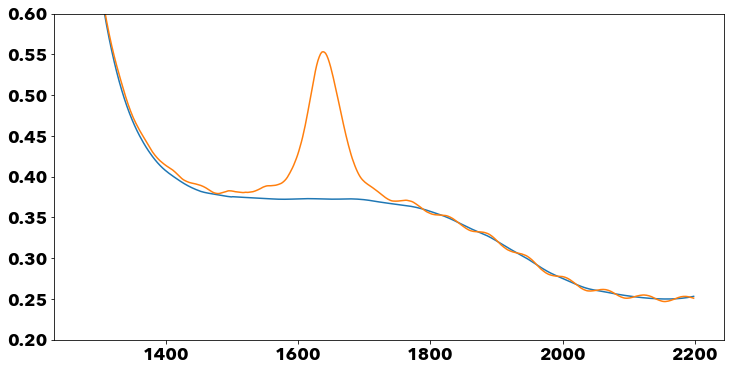

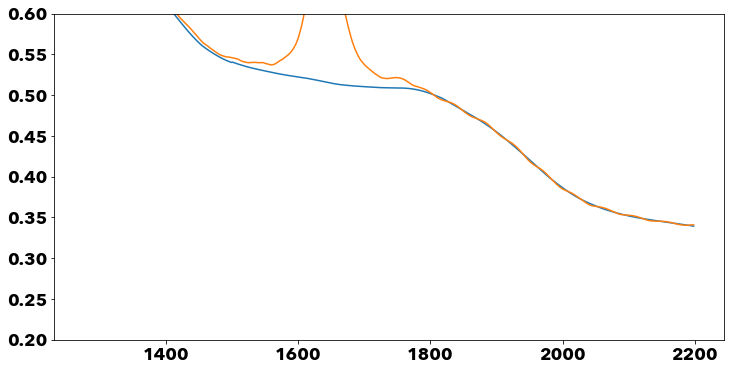

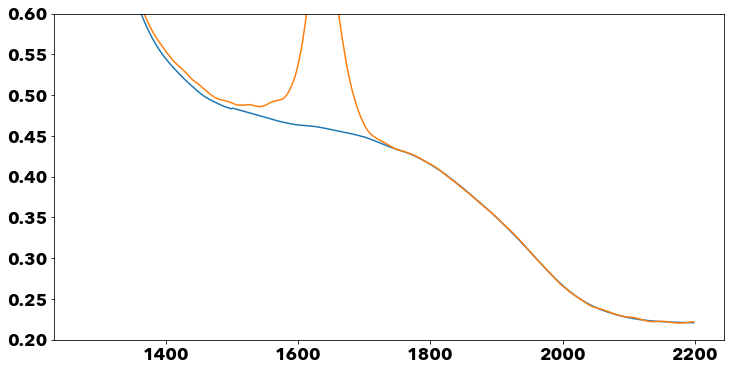

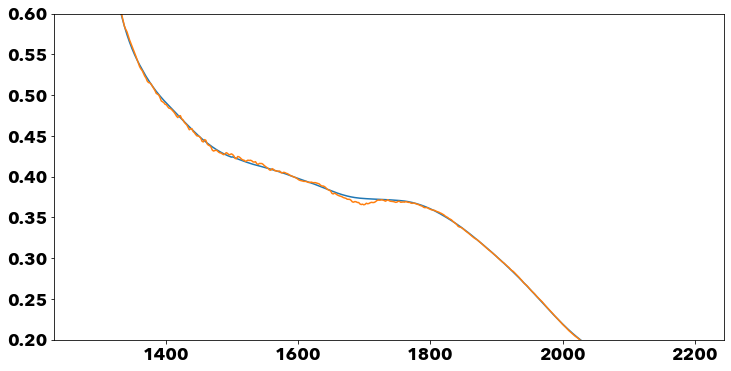

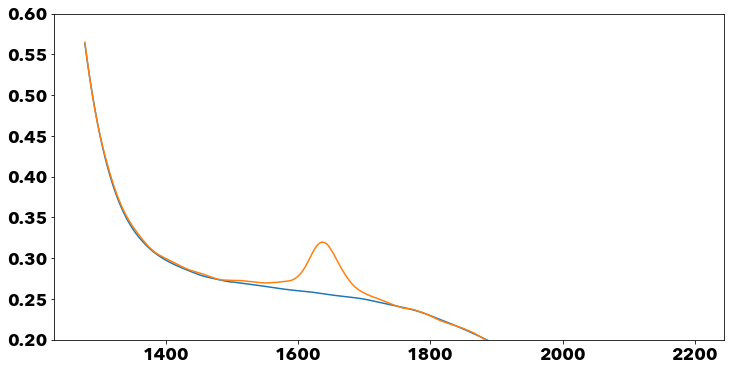

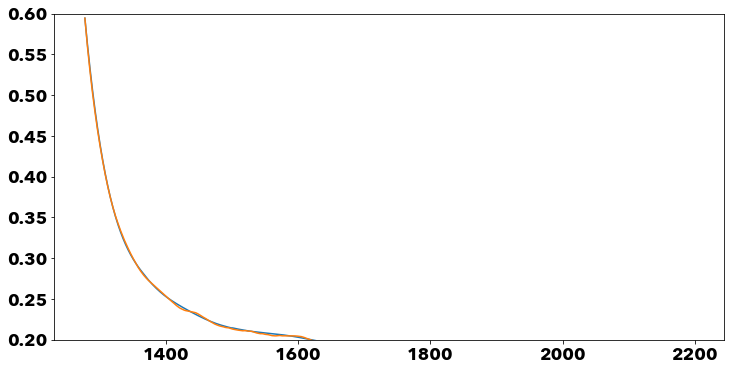

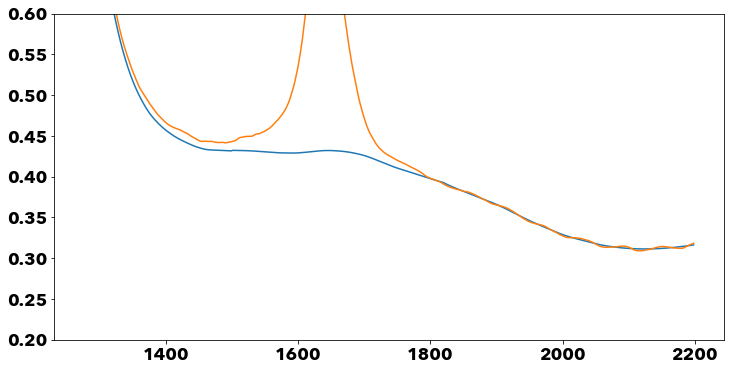

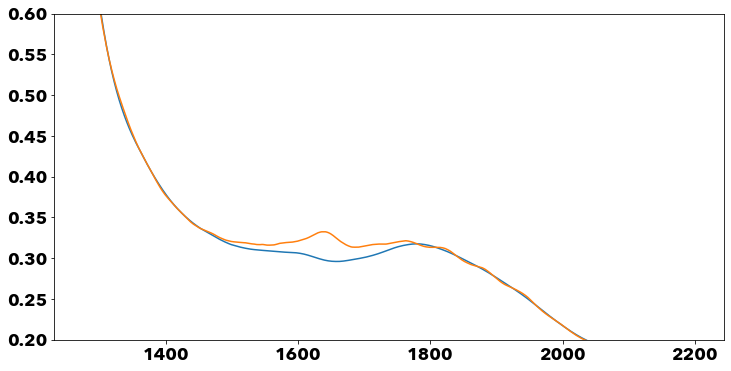

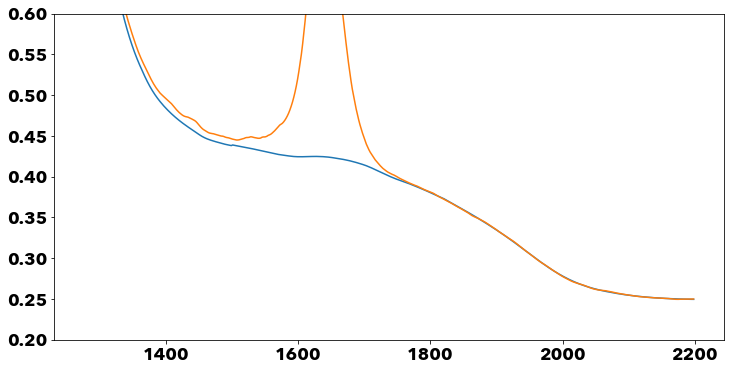

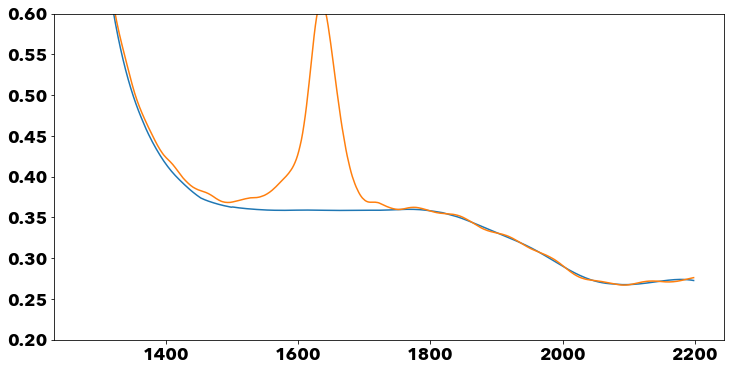

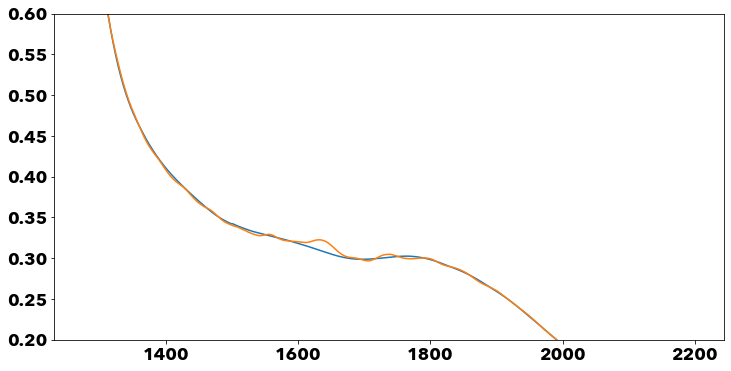

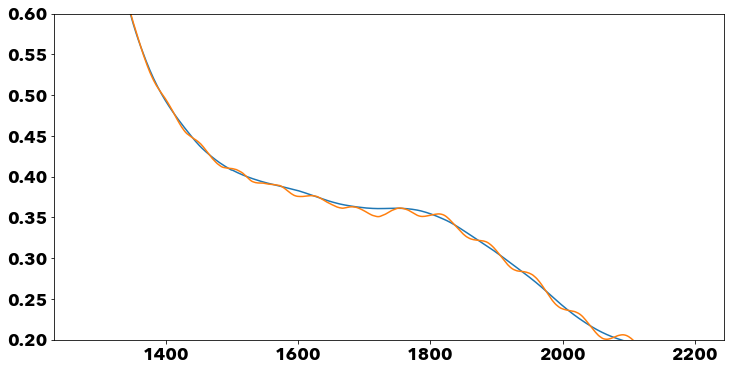

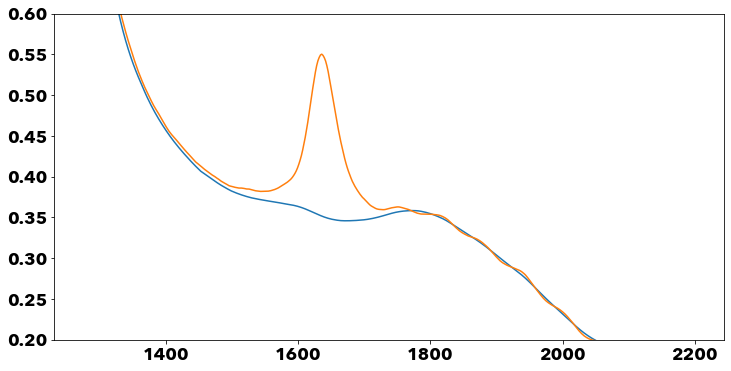

In [39]:
for idx, spec in enumerate(Peaks_removed_full_DF):  # Peaks_removed_full_DF.iteritems():
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(Peaks_removed_full_DF.iloc[:, idx])
    plt.plot(H2O_frame_select.iloc[:, idx])
    plt.ylim(0.2, 0.6)

In [41]:
# Devol Baselines saved


# def savgol_filter_short(x):
#     return signal.savgol_filter(x, 51, 3)

# TODO decide if the original water free spectra need to be added back in.
Peaks_removed_full = pd.concat((Peaks_removed_full_DF, Smoothed_DF), axis=1)

# Mayeb comment out this next section
# Peaks_removed_full = Peaks_removed_full_DF.apply(
#     func=signal.savgol_filter, args=(31, 3)
# )
Peaks_removed_full = pd.DataFrame(
    Peaks_removed_full,
    index=Peaks_removed_full_DF.index,
    # columns=Peaks_removed_full_DF.columns,
)


Data_start = Peaks_removed_full.values

# Peaks_removed_full.to_csv('CO2_free_baselines_Water_removed_5-4-21.csv')


In [42]:

# Smooth_Data, Smooth_Mean_baseline = scale_data(Peaks_removed_full_DF.values, Wavenumber)
Smooth_Data, Smooth_Mean_baseline = scale_data(Peaks_removed_full.values, Wavenumber)
# Data, Mean_baseline = Data_smoothed, Mean_baseline_smoothed #Smooth_Data, Smooth_Mean_baseline
Data, Mean_baseline = Smooth_Data, Smooth_Mean_baseline


In [43]:

# Calculates the Principle components
pca = PCA(
    12,
)  # Number of PCA vectors to calculate

principalComponents = pca.fit(
    Data.T
)  # everything appears to work best with the raw data or raw data scaled

reduced_data = pca.fit(Data.T).transform(Data.T)

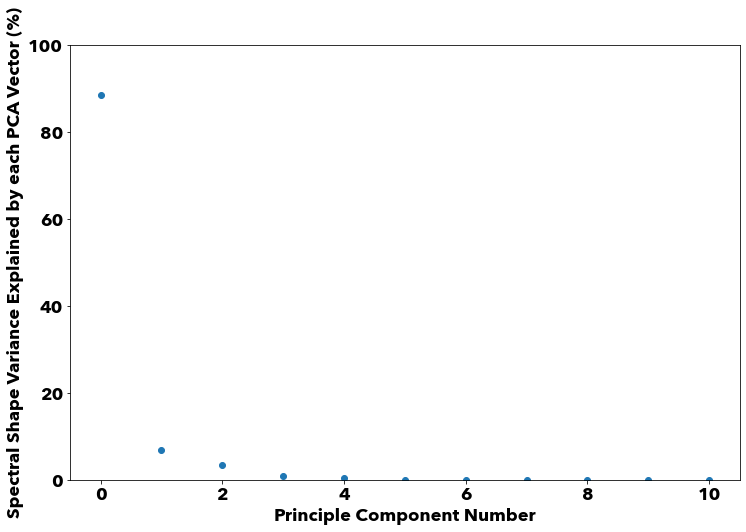

In [46]:

# plots the fraction of the variance explained by each PCA vector
fig, ax = plt.subplots(figsize=(12, 8))
variance = pca.explained_variance_
variance_norm = variance[0:-1] / np.sum(variance[0:-1])
plt.plot(variance_norm * 100, marker="o", linestyle="None")
ax.set_xlabel("Principle Component Number")
ax.set_ylabel(f"Spectral Shape Variance Explained by each PCA Vector (%)")
ax.set_ylim(0,100)
pca.singular_values_
PCA_vectors = pca.components_
plt.savefig("PCA_Variance_plot_H2O_removed.png")

# TODO Smooth PCA before final output

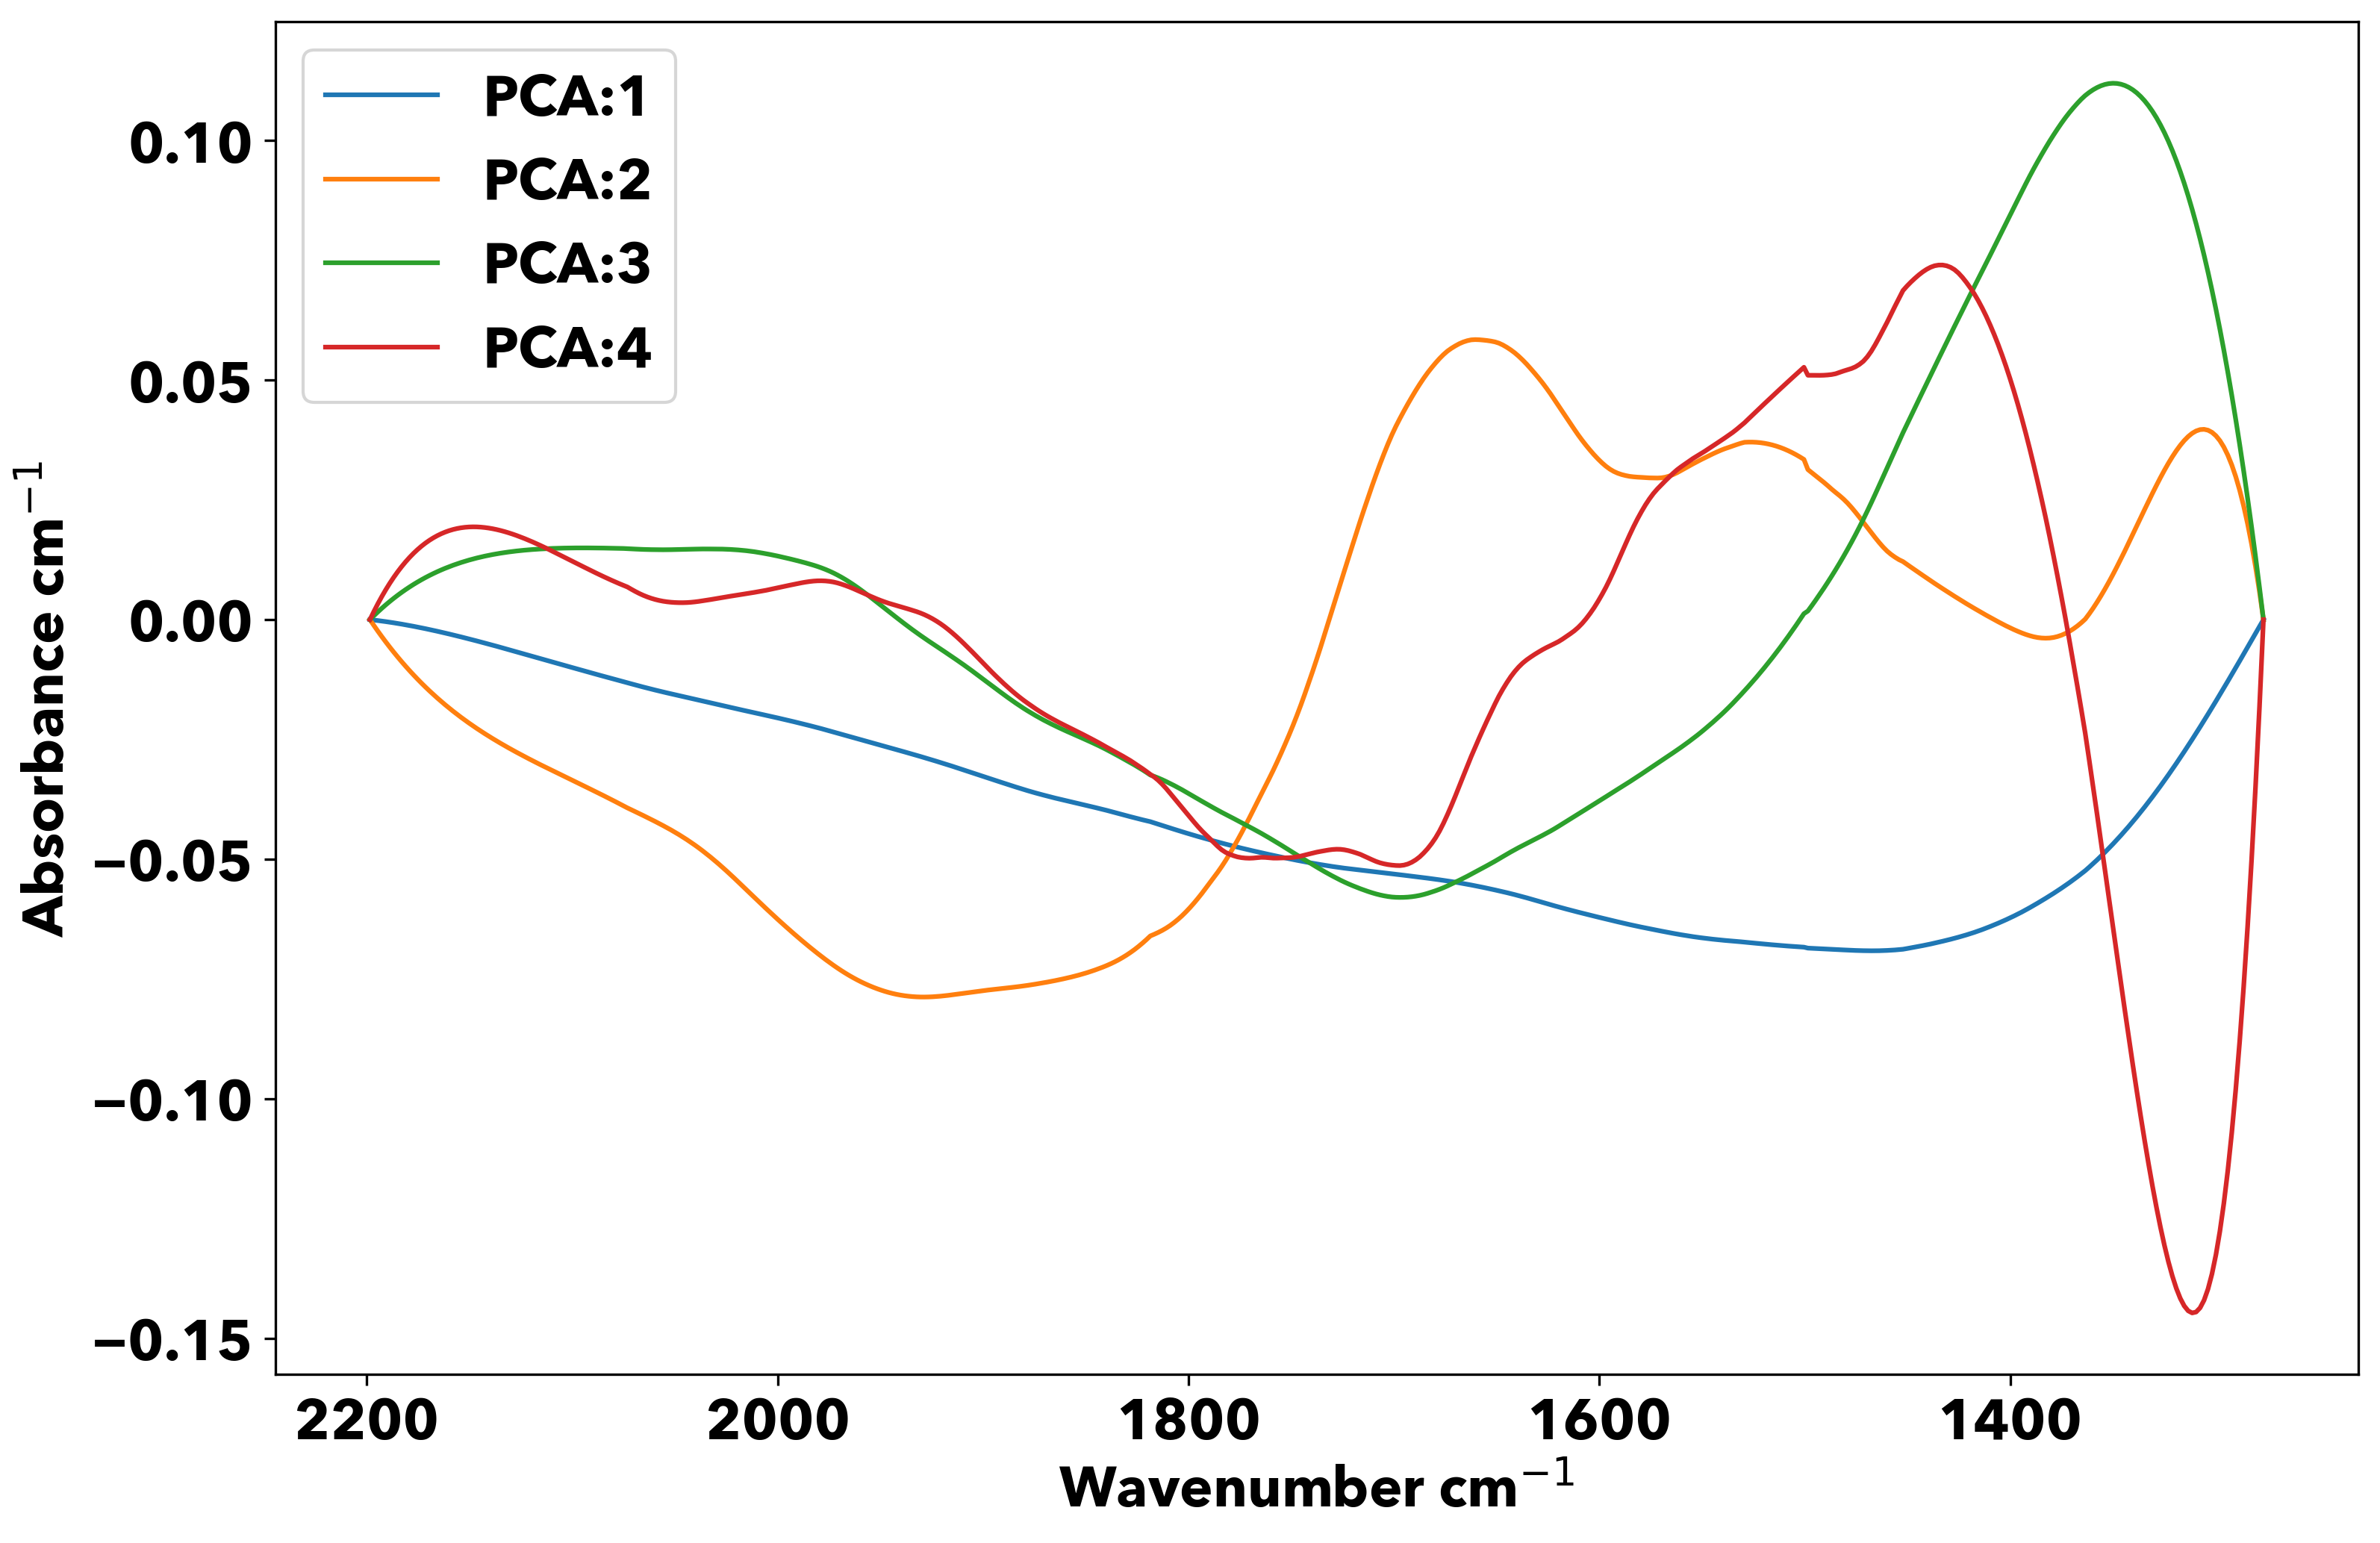

In [47]:
# Plots the first several principle components

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
plt.plot(Wavenumber_full, PCA_vectors[0], label="PCA:1")
plt.plot(Wavenumber_full, PCA_vectors[1], label="PCA:2")
plt.plot(Wavenumber_full, PCA_vectors[2], label="PCA:3")
plt.plot(Wavenumber_full, PCA_vectors[3], label="PCA:4")
# plt.plot(Wavenumber, PCA_vectors[4], label="PCA:5")
# plt.plot(Wavenumber, PCA_vectors[5], label="PCA:6")
# plt.plot(Wavenumber, PCA_vectors[6], label="PCA:7")
# plt.plot(Wavenumber, PCA_vectors[7], label="PCA:8")


plt.legend()
ax.invert_xaxis()
ax.legend()
ax.set_ylabel(f"Absorbance cm$^{{-1}}$")
ax.set_xlabel(f"Wavenumber cm$^{{-1}}$")
plt.savefig("component_plot.png")

Text(0, 0.5, 'PCA 2')

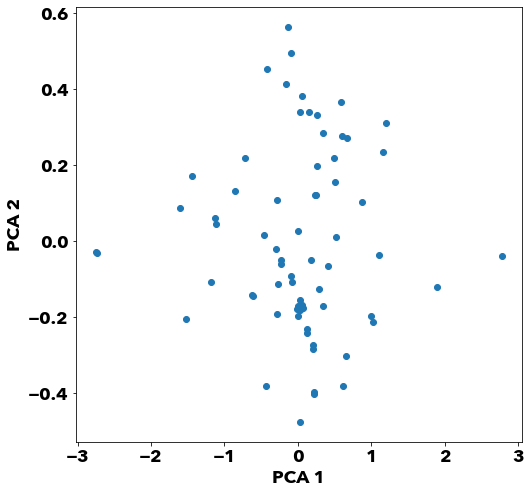

In [48]:
# Plots the baseline database in terms of PCA component.
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")